In [1]:
'''
代码主要包括四大部分：
1. 特征选择
2. 选择最优模型
3. 调整超参数
4. 解释模型
'''

'\n代码主要包括四大部分：\n1. 特征选择\n2. 选择最优模型\n3. 调整超参数\n4. 解释模型\n'

In [1]:
#-*- coding: utf-8 -*- 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, roc_auc_score,f1_score
from sklearn.impute import KNNImputer, SimpleImputer
from xgboost.sklearn import XGBClassifier
from IPython.core.pylabtools import figsize
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from scipy import interp
import csv
from collections import Counter


from imblearn.pipeline import Pipeline
from fpdf import FPDF
import shap
import random
import math
import os
from sklearn.preprocessing import MinMaxScaler, StandardScaler
SEED=50

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [3]:
#寻找最佳截断值
def  seek_optimal_threshold(y_group,y_score):
    fpr, tpr, thresholds = roc_curve(y_group,y_score)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold

In [2]:
#1. 读取数据，不需要的特征进行删除，统计缺失值
file = 'data_encoding_process_final_old.csv'
data_df = pd.read_csv(file)
data_df = data_df.replace(to_replace=r'^\s*$', value=np.nan, regex=True)
data_df.head()

Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.


PATIENT_ID  VISIT_ID NAME  SEX  AGE  operation_grade  心房颤动  急性冠脉综合征  严重心率失常  \
0       6608         7   计敏    0   77              1.0     0        0       0   
1       7407        13  郑固玉    0   70              1.0     0        0       0   
2       7407        16  郑固玉    0   74              1.0     0        0       0   
3       7849         8  穆芝荣    0   74              2.0     0        1       0   
4       8042         7  潘茵帆    0   87              2.0     1        0       0   

   原发性心肌病  ...    氯-加  丙氨酸氨基转移酶-加  总胆红素-加    BMI    脉搏    呼吸  血压high  血压Low  \
0       0  ...   99.9        15.0     9.5  32.46  84.0  20.0   110.0   56.0   
1       0  ...  110.3        17.0    17.4  22.04  74.0  17.0   132.0   74.0   
2       0  ...  109.9        10.2    12.9  21.67  78.0  18.0   128.0   77.0   
3       0  ...  101.7        10.5     7.3  24.84  54.0  20.0   125.0   60.0   
4       0  ...  105.2        17.4    10.7  24.34  76.0  19.0   125.0   75.0   

   白细胞计数  直接胆红素-加  
0   8.02      4.7  
1   3.27      1.6  
2   3.62      2.9  
3   7.46      3.0  
4   6.19      2.9  

[5 rows x 70 columns]

In [3]:
print(data_df.group.value_counts())
print(data_df.shape)

group
0    25309
1      881
Name: count, dtype: int64
(26190, 70)


In [4]:
data_df.死亡.value_counts()

死亡
0    25882
1      308
Name: count, dtype: int64

In [4]:
data_df.drop(['PATIENT_ID','VISIT_ID','NAME','死亡'],axis=1,inplace=True)
data_df.head()

SEX  AGE  operation_grade  心房颤动  急性冠脉综合征  严重心率失常  原发性心肌病  瓣膜性心肌病（风湿性、退行性）  \
0    0   77              1.0     0        0       0       0                0   
1    0   70              1.0     0        0       0       0                0   
2    0   74              1.0     0        0       0       0                0   
3    0   74              2.0     0        1       0       0                0   
4    0   87              2.0     1        0       0       0                0   

   急性中毒（酒精、一氧化碳、化学毒物）  慢性阻塞性肺疾病急性加重  ...    氯-加  丙氨酸氨基转移酶-加  总胆红素-加    BMI  \
0                   0             0  ...   99.9        15.0     9.5  32.46   
1                   0             0  ...  110.3        17.0    17.4  22.04   
2                   0             0  ...  109.9        10.2    12.9  21.67   
3                   0             0  ...  101.7        10.5     7.3  24.84   
4                   0             1  ...  105.2        17.4    10.7  24.34   

     脉搏    呼吸  血压high  血压Low  白细胞计数  直接胆红素-加  
0  84.0  20.0   110.0   56.0   8.02      4.7  
1  74.0  17.0   132.0   74.0   3.27      1.6  
2  78.0  18.0   128.0   77.0   3.62      2.9  
3  54.0  20.0   125.0   60.0   7.46      3.0  
4  76.0  19.0   125.0   75.0   6.19      2.9  

[5 rows x 66 columns]

In [5]:
data_df = data_df[data_df['淋巴细胞绝对值']>0]

In [6]:
NLR = data_df['中性粒细胞绝对值']/data_df['淋巴细胞绝对值']
data_df.insert(66,'中性粒细胞与淋巴细胞比值',NLR)
data_df.head()

SEX  AGE  operation_grade  心房颤动  急性冠脉综合征  严重心率失常  原发性心肌病  瓣膜性心肌病（风湿性、退行性）  \
0    0   77              1.0     0        0       0       0                0   
1    0   70              1.0     0        0       0       0                0   
2    0   74              1.0     0        0       0       0                0   
3    0   74              2.0     0        1       0       0                0   
4    0   87              2.0     1        0       0       0                0   

   急性中毒（酒精、一氧化碳、化学毒物）  慢性阻塞性肺疾病急性加重  ...  丙氨酸氨基转移酶-加  总胆红素-加    BMI    脉搏  \
0                   0             0  ...        15.0     9.5  32.46  84.0   
1                   0             0  ...        17.0    17.4  22.04  74.0   
2                   0             0  ...        10.2    12.9  21.67  78.0   
3                   0             0  ...        10.5     7.3  24.84  54.0   
4                   0             1  ...        17.4    10.7  24.34  76.0   

     呼吸  血压high  血压Low  白细胞计数  直接胆红素-加  中性粒细胞与淋巴细胞比值  
0  20.0   110.0   56.0   8.02      4.7      1.346457  
1  17.0   132.0   74.0   3.27      1.6      2.159574  
2  18.0   128.0   77.0   3.62      2.9      1.944954  
3  20.0   125.0   60.0   7.46      3.0      2.694737  
4  19.0   125.0   75.0   6.19      2.9      2.214286  

[5 rows x 67 columns]

In [7]:
data_df = data_df[data_df['中性粒细胞与淋巴细胞比值']<110]
data_df = data_df[data_df['eGFR']<500]
data_df = data_df[data_df['呼吸']<40]
data_df = data_df[data_df['平均血红蛋白浓度']<400]

In [8]:
data_df['肌酐-加'] = np.where(data_df['肌酐-加']>2000,np.nan,data_df['肌酐-加'])
data_df['肌酐-加'] = data_df['肌酐-加'].fillna(data_df['肌酐-加'].median())

In [9]:
data_df['丙氨酸氨基转移酶-加'] = np.where(data_df['丙氨酸氨基转移酶-加']>5000,np.nan,data_df['丙氨酸氨基转移酶-加'])
data_df['丙氨酸氨基转移酶-加']= data_df['丙氨酸氨基转移酶-加'].fillna(data_df['丙氨酸氨基转移酶-加'].median())

In [10]:
data_df['直接胆红素-加'] = np.where(data_df['直接胆红素-加']>500,np.nan,data_df['直接胆红素-加'] )
data_df['直接胆红素-加'] = data_df['直接胆红素-加'] .fillna(data_df['直接胆红素-加'].median())

In [11]:
data_df['部分凝血活酶时间'] = np.where(data_df['部分凝血活酶时间']>150,np.nan,data_df['部分凝血活酶时间'] )
data_df['部分凝血活酶时间'] = data_df['部分凝血活酶时间'] .fillna(data_df['部分凝血活酶时间'].median())

In [12]:
data_df['group'].value_counts()

group
0    25156
1      870
Name: count, dtype: int64

In [13]:
file_EN = pd.read_csv('英汉对照.csv',encoding='GB18030')
file_EN.head()

中文                英文                        NOTE
0    AGE               Age                         NaN
1  白蛋白-加           Albumin                         ALB
2   eGFR              eGFR  Glomerular filtration rate
3  总蛋白-加     Total protein                         NaN
4   肌酐-加  Serum creatinine                         Scr

In [14]:
####生成新的英文名称数据框
dict_name = dict(zip(file_EN['中文'],file_EN['英文']))
data_df_EN = data_df.copy()
data_df_EN.rename(columns=dict_name,inplace=True)
data_df_EN.head()

Sex  Age  Surgical risk classfication  Atrial fibrillation  \
0    0   77                          1.0                    0   
1    0   70                          1.0                    0   
2    0   74                          1.0                    0   
3    0   74                          2.0                    0   
4    0   87                          2.0                    1   

   Acute coronary syndrome  Severe arrhythmia  Primary cardiomyopathy  \
0                        0                  0                       0   
1                        0                  0                       0   
2                        0                  0                       0   
3                        1                  0                       0   
4                        0                  0                       0   

   Valvular heart disease  Acute poisoning  AECOPD  ...  \
0                       0                0       0  ...   
1                       0                0       0  ...   
2                       0                0       0  ...   
3                       0                0       0  ...   
4                       0                0       1  ...   

   Alanine aminotransfease  Total bilirubin    BMI  Pulse  Respiratory rate  \
0                     15.0              9.5  32.46   84.0              20.0   
1                     17.0             17.4  22.04   74.0              17.0   
2                     10.2             12.9  21.67   78.0              18.0   
3                     10.5              7.3  24.84   54.0              20.0   
4                     17.4             10.7  24.34   76.0              19.0   

   Systolic blood pressure  Diastolic blood pressure  White blood cell count  \
0                    110.0                      56.0                    8.02   
1                    132.0                      74.0                    3.27   
2                    128.0                      77.0                    3.62   
3                    125.0                      60.0                    7.46   
4                    125.0                      75.0                    6.19   

   Direct bilirubin       NLR  
0               4.7  1.346457  
1               1.6  2.159574  
2               2.9  1.944954  
3               3.0  2.694737  
4               2.9  2.214286  

[5 rows x 67 columns]

In [101]:
#生成后注释掉，会改变数据类型
from clinical_baseline import baseline_type
data_merge_cli1 = baseline_type(data_df,label='group')
data_merge_cli1.to_csv('final_baseline_type_label.csv')
data_merge_cli2 = baseline_type(data_df_EN,label='group')
data_merge_cli2.to_csv('final_baseline_type_label_EN.csv')

In [102]:
round(data_df.describe().T,3).to_csv('describe.csv')
round(data_df_EN.describe().T,3).to_csv('describe_EN.csv')

In [11]:
#2. 分类变量进行编码

In [7]:
#data_df['smoke'] = data_df['smoke'].map({'Yes': 1, 'No': 0})
#data_df['alcohol'] = data_df['alcohol'].map({'Yes': 1, 'No': 0})
#data_df['gender'] = data_df['gender'].map({'male': 1, 'female': 2})
#data_df['education'] = data_df['education'].map({'junior high school or below': 1, 'senior high school or above': 2})
#data = data_df.dropna(subset=['group'], inplace=False,axis=0)
#data = data.reset_index(drop = True)
# data_df['风险评估'] = data_df['风险评估'].map({'低风险':0, '中风险':1,'高风险':2})

In [ ]:
# #3. 填充缺失值
# imr = SimpleImputer(strategy='median')
# imputed_data = imr.fit_transform(data_df)
# data = pd.DataFrame(data=imputed_data,columns=data_df.columns.tolist())
# data.info()
# data.head()

In [9]:
# data = data_df

In [15]:
data = data_df[['AGE','平均血红蛋白浓度','谷氨酰转肽酶','尿酸-加','钠-加','钾-加','钙-加','总蛋白-加','白蛋白-加','eGFR','肌酐-加','淋巴细胞绝对值','中性粒细胞绝对值',
'中性粒细胞百分比','单核细胞绝对值','血小板计数','凝血酶原时间','部分凝血活酶时间','纤维蛋白原定量','国际标准化比率','碱性磷酸酶','血清磷','氯-加','丙氨酸氨基转移酶-加',
'总胆红素-加','BMI','脉搏','呼吸','血压high','血压Low','白细胞计数','直接胆红素-加','中性粒细胞与淋巴细胞比值']]
data_EN = data.rename(columns=dict_name)

In [16]:
#4. 分析各变量之间的相关性
def pearson_heatmap(data,figname,fontsize,fontype,filename):
    import seaborn as sns
    %matplotlib inline
    plt.figure(figsize=(10,11), dpi=300)   #
    sns.set(palette="muted", color_codes=True) 
    plt.rcParams['font.sans-serif'] = [fontype]
    plt.rcParams['axes.unicode_minus'] = False
    # df = data[data.corr()['group'].sort_values(ascending=False,inplace=False).index].corr().round(2)
    df = data.corr().round(2)
    extremes = df.values.max(), df.values.min()
    labels = df.applymap(lambda v: v if v in (extremes) else '')
    sns.heatmap(df, cmap='coolwarm', square=True, linewidths=0.5,
      annot_kws={'size': 5, 'alpha': 0.8}, 
      # annot=labels,
      annot=True,
      fmt = '', cbar_kws={"shrink": 0.3},
      vmax=extremes[0], vmin=-extremes[0])
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.savefig(figname,bbox_inches='tight')
    df.to_csv(filename)



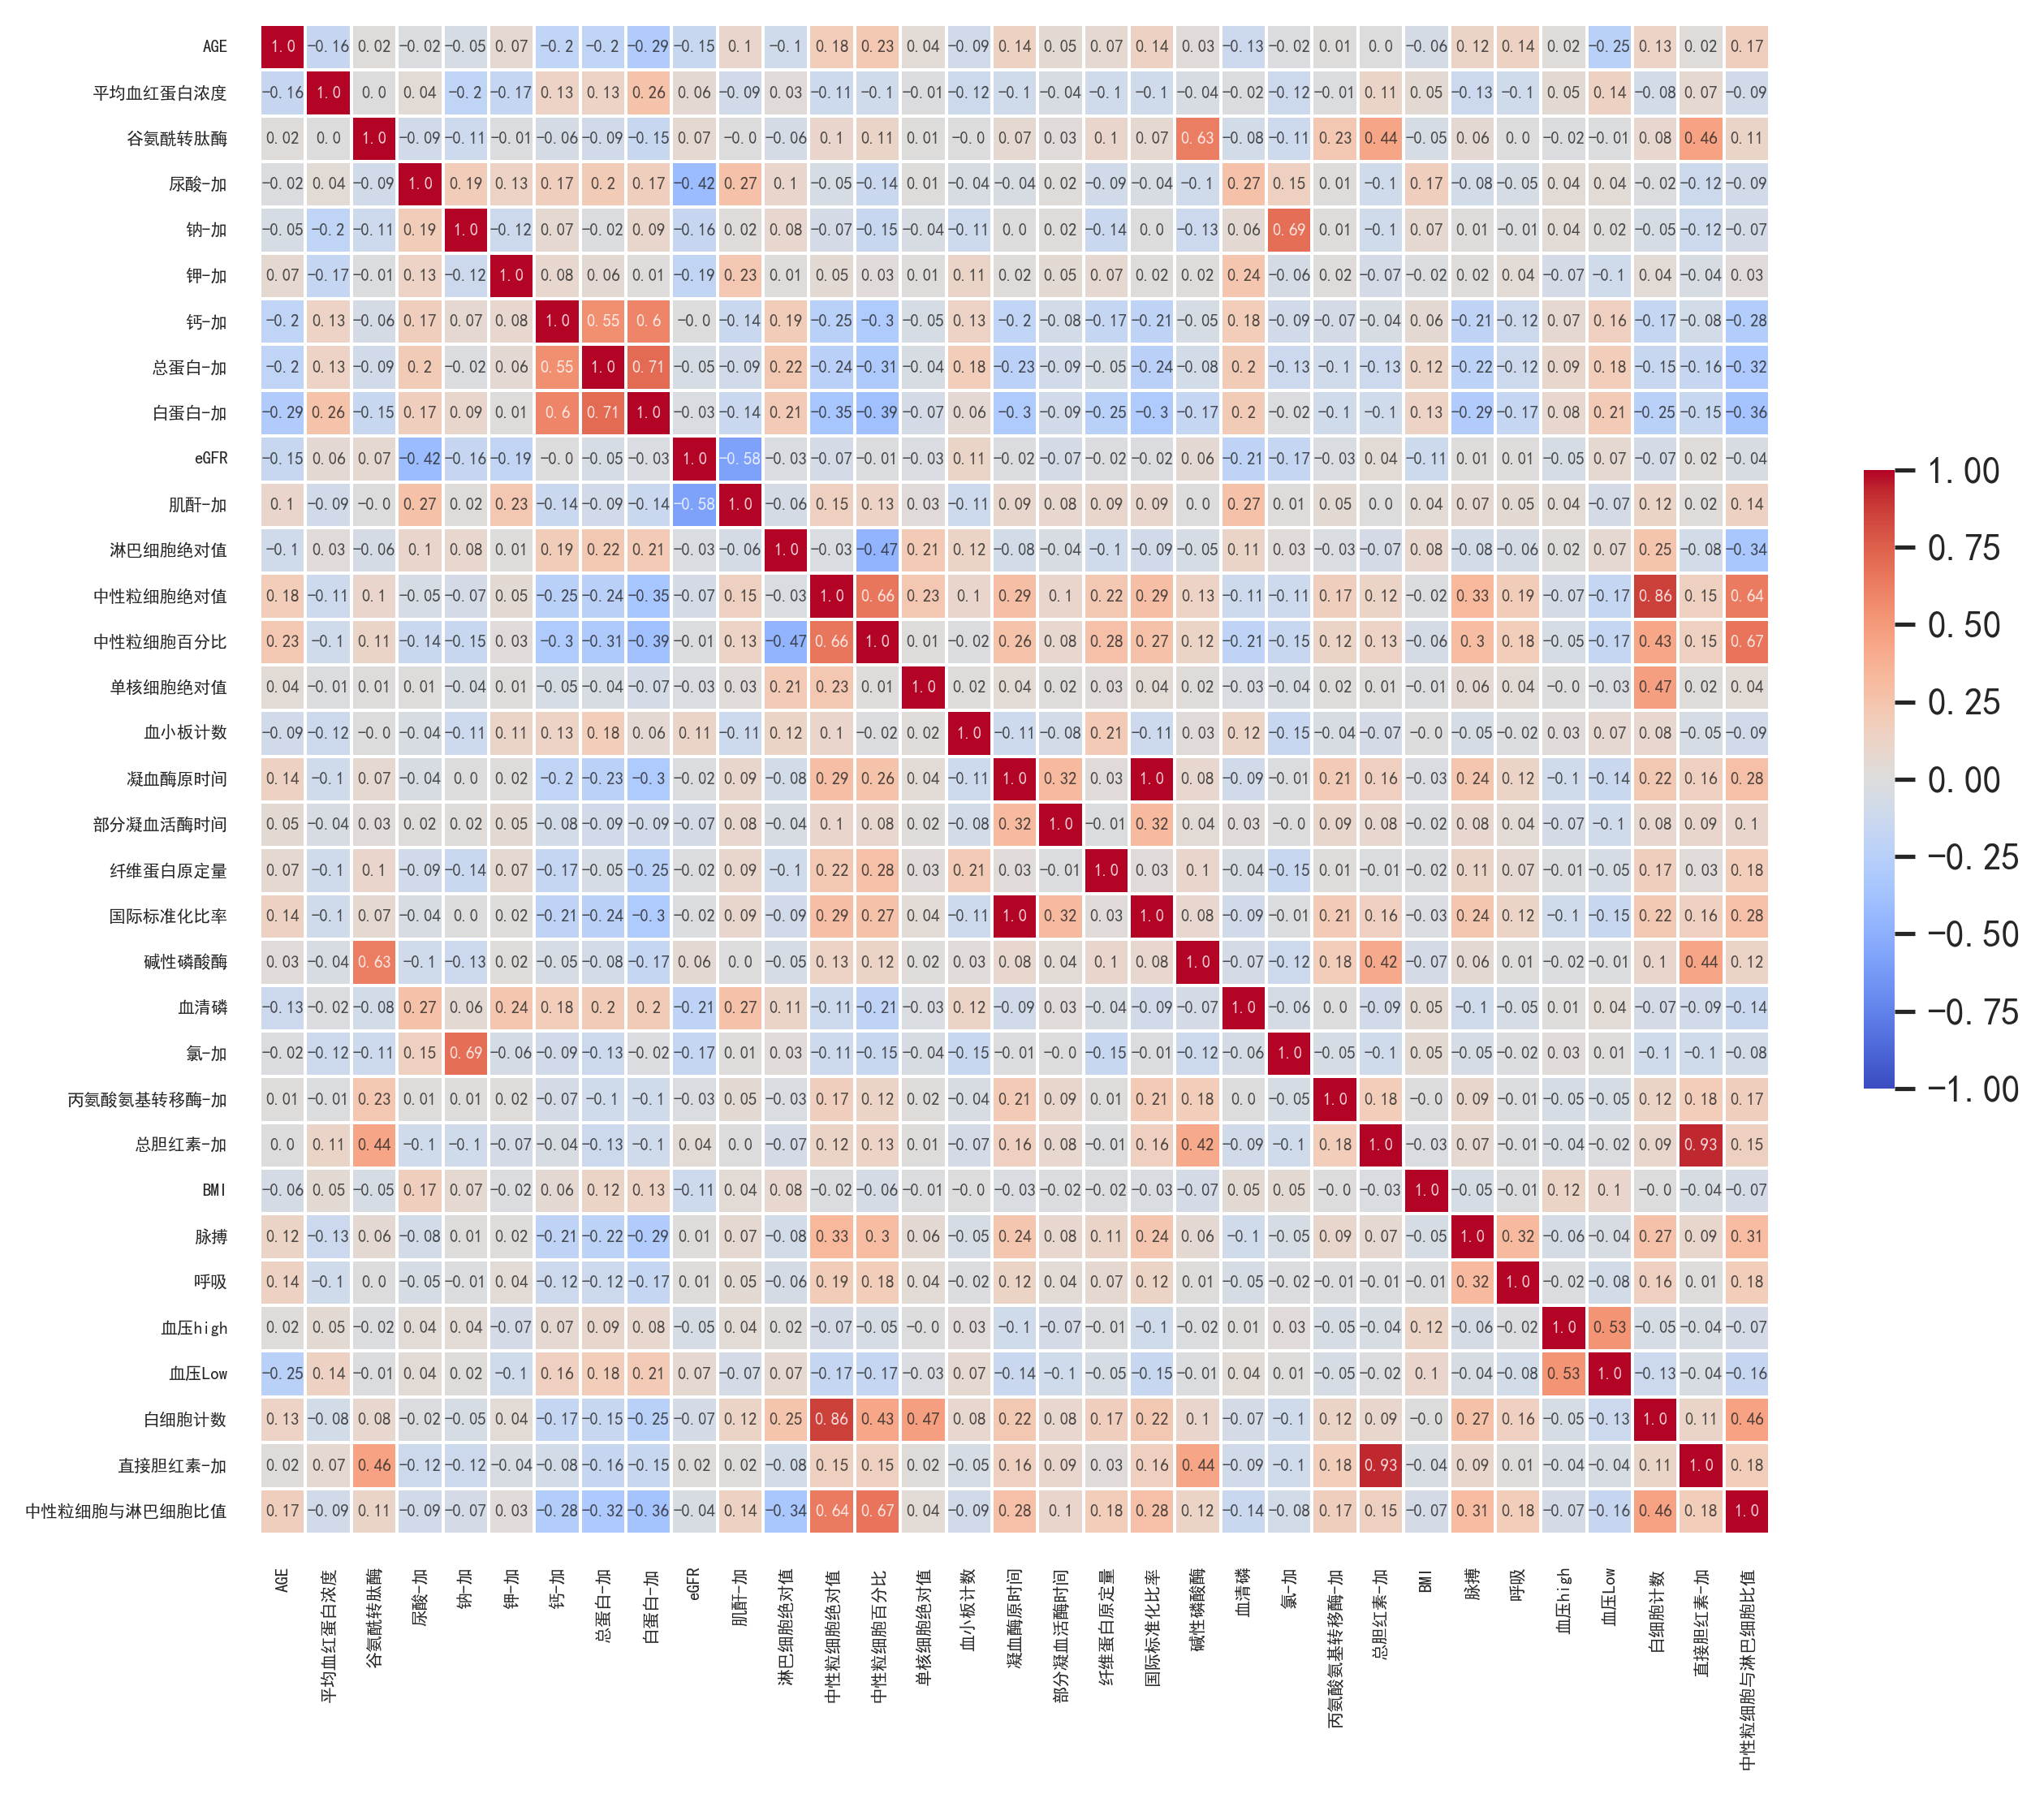

In [17]:
pearson_heatmap(data,'pearson_heatmap.png',5,'SimHei','corr.csv')    #SimHei

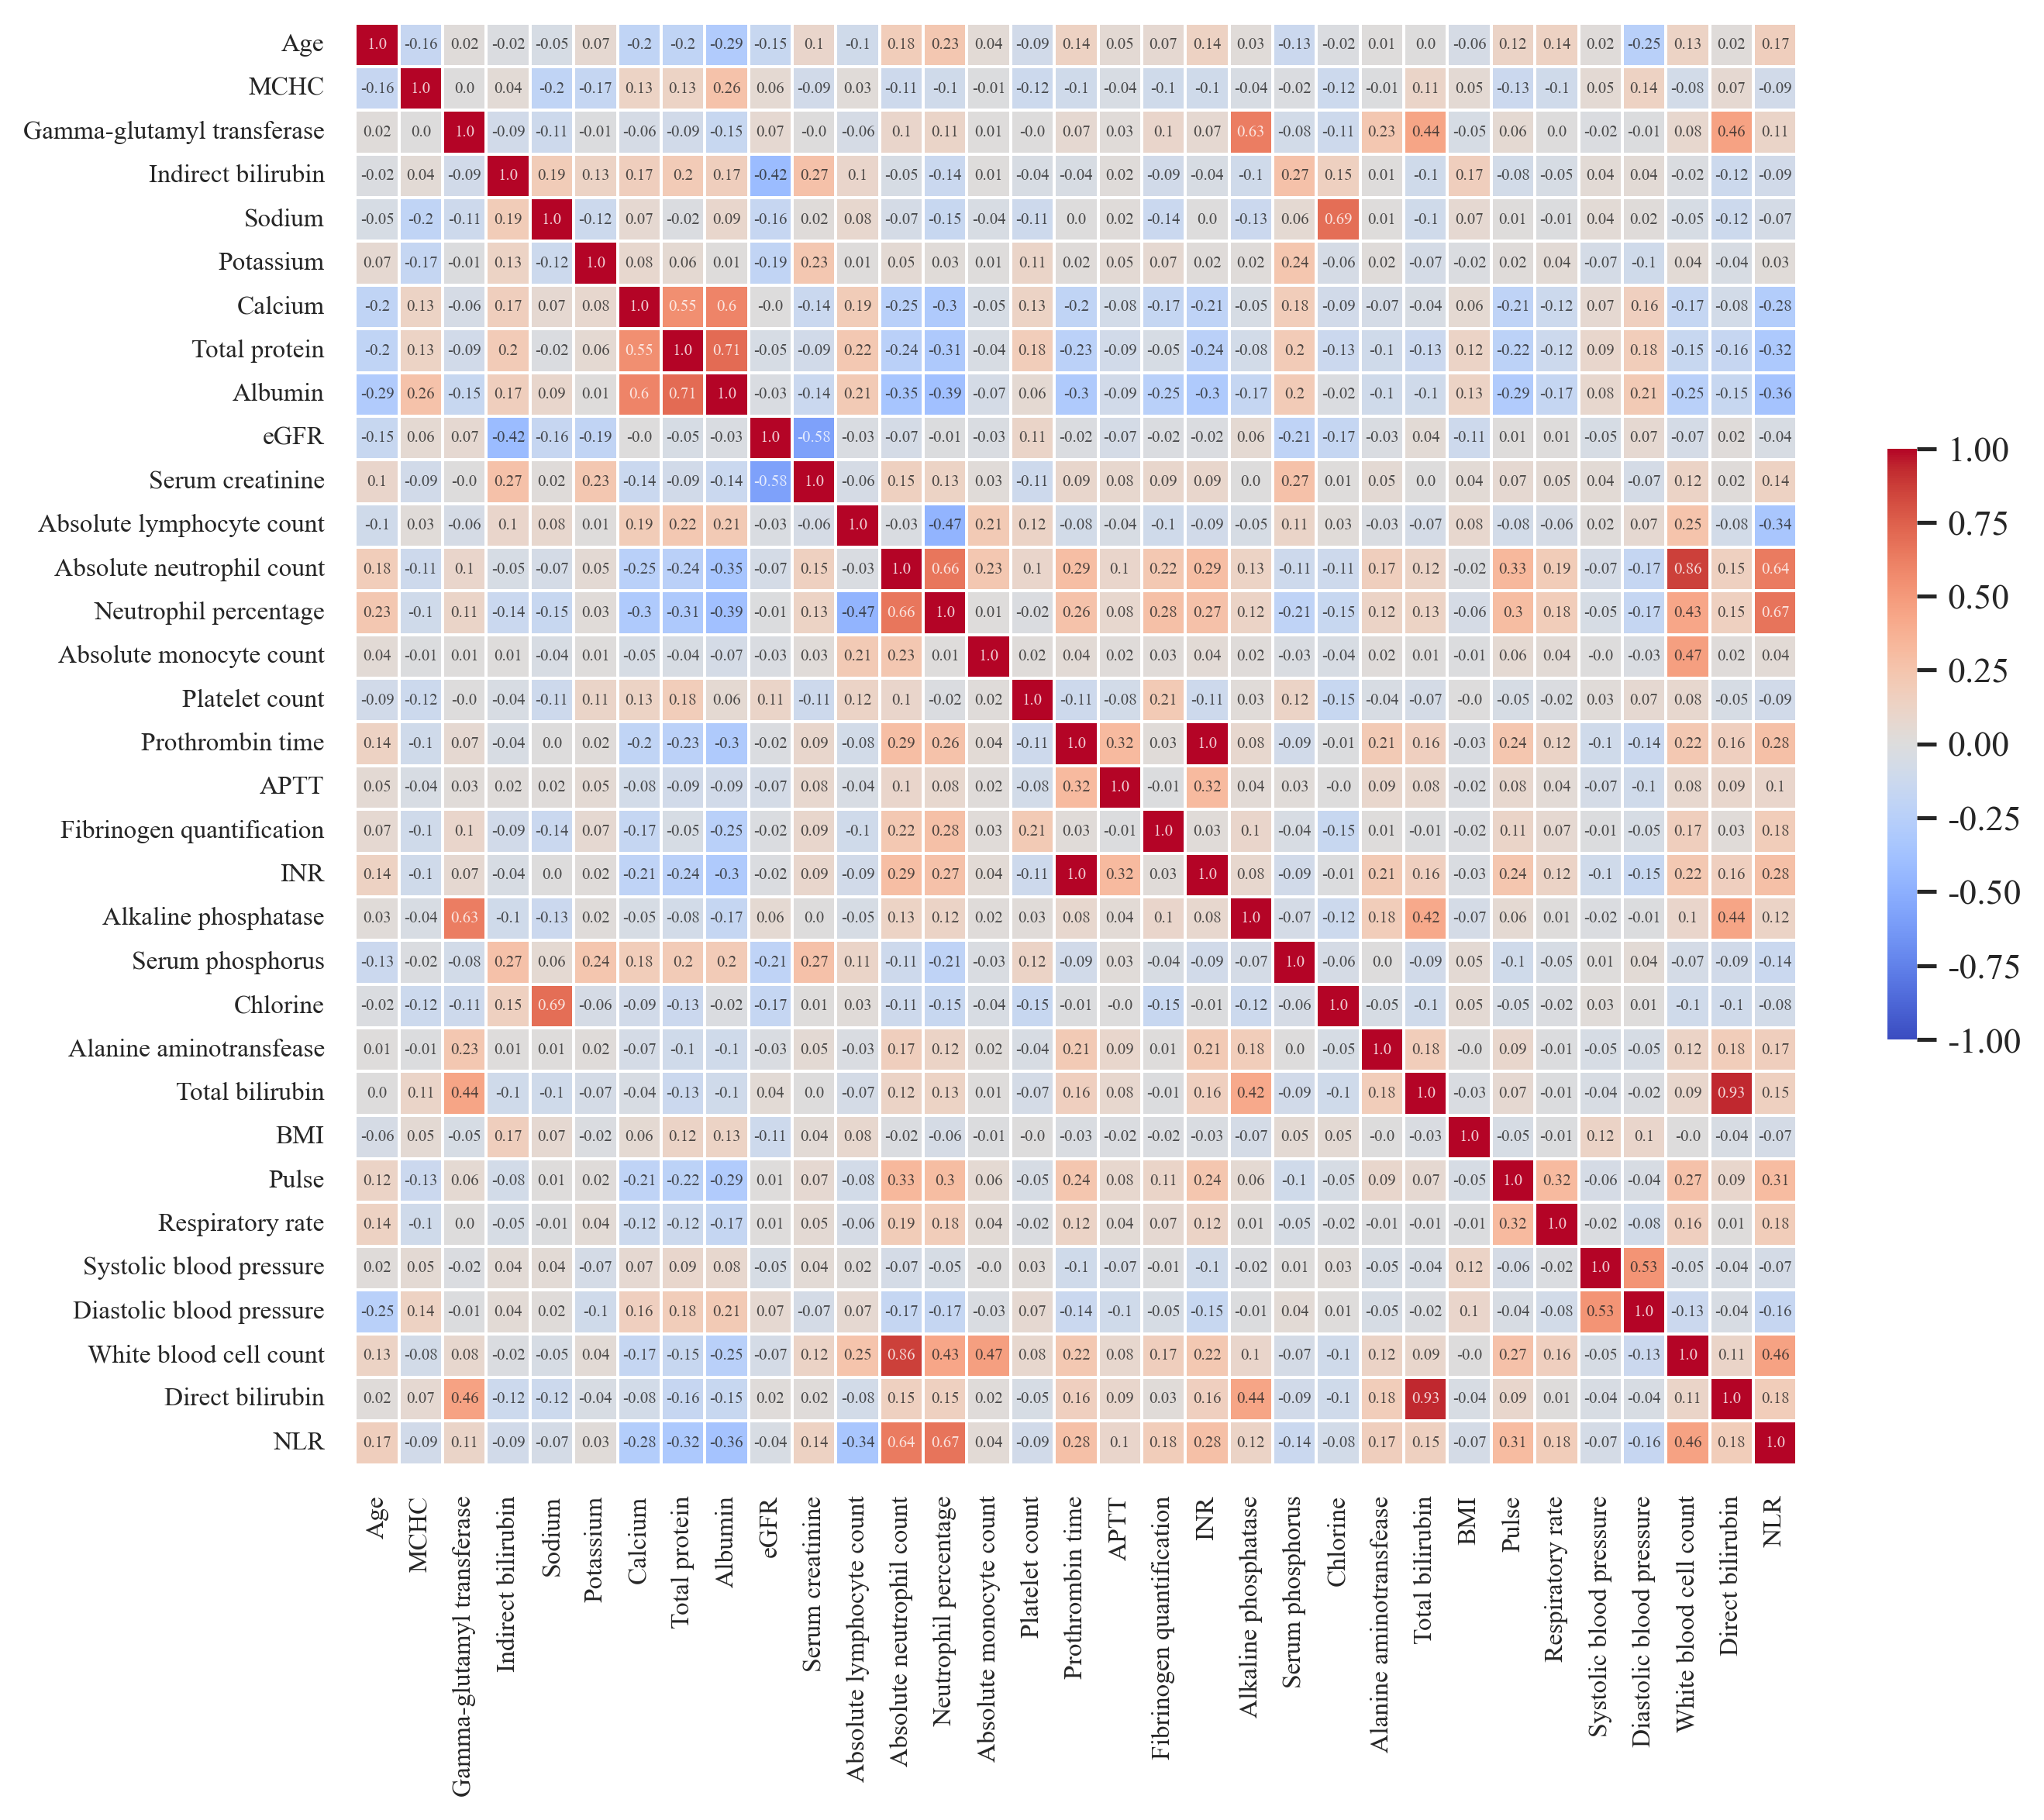

In [18]:
pearson_heatmap(data_EN,'pearson_heatmap_EN.png',8,'Times New Roman','corr_EN.csv') 

In [15]:
# data.drop('中性粒细胞百分比',axis=1,inplace=True)

In [95]:
def count_missing_values(dataframe):
    
    total = dataframe.isnull().sum()
    percent = (dataframe.isnull().sum())*100/(len(dataframe))
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    missing_data = missing_data[missing_data['Total']>0]
    missing_data.sort_values('Total', ascending=False, inplace=True)
    print(missing_data)
    
    return 

count_missing_values(data)

Empty DataFrame
Columns: [Total, Percent]
Index: []


In [19]:
y = data_df['group']
X = data_df.drop(['group'], axis = 1)

In [ ]:
#5. 数据归一化
# scaler = MinMaxScaler(feature_range=(0, 1))

In [18]:
def Las_SF(X,y,number):
    model = Lasso(alpha=0.01,max_iter=2000)
    model.fit(X, y)
    newcolumns = pd.Series(data=model.coef_, index=X.columns).abs().nlargest(number).index
    print('已基于Lasso回归选择了' + str(number) + '个特征，分别是：')
    print(newcolumns)
    return newcolumns
def RF_SF(X,y,number):
    model = RandomForestClassifier()
    model.fit(X, y)
    newcolumns = pd.Series(data=model.feature_importances_, index=X.columns).abs().nlargest(number+1).index
    print('已基于随机森林选择了' + str(number) + '个特征，分别是：')
    print(newcolumns)
    return newcolumns
def mutual_information(X,y,number):
    selector = SelectKBest(score_func=mutual_info_classif, k=number)
    selector.fit(X,y)
    newcolumns = X.columns[selector.get_support()]
    print('已基于mutual information选择了' + str(number) + '个特征，分别是：')
    print(newcolumns)
    return newcolumns

In [21]:
#下采样
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=SEED,sampling_strategy='auto')
X_UnS, y_UnS = rus.fit_resample(X, y)


In [23]:
X_UnS.reset_index(inplace=True,drop=True)
y_UnS.reset_index(inplace=True,drop=True)

In [25]:
#5. 数据拆分为训练集与测试集，采用上采样使数据类别保持平衡
X_train, X_test, y_train, y_test = train_test_split(X_UnS, y_UnS, stratify=y_UnS, test_size=0.2, random_state=SEED)
# X_train_scaled, y_train_scaled = SMOTE(sampling_strategy='auto', random_state=SEED).fit_resample(X_train, y_train)

In [ ]:
# from sklearn.linear_model import Lasso,LassoCV
# # newcolumns = RF_SF(X_train_scaled, y_train_scaled,30)
# newcolumns = mutual_information(X_train_scaled, y_train_scaled,30)
# X_train, X_test = X_train[newcolumns], X_test[newcolumns]
# X_train_scaled = X_train_scaled[newcolumns]

In [26]:
print(X_train.shape, X_test.shape)
print(Counter(y_train))
print(Counter(y_test))

(1392, 66) (348, 66)
Counter({1: 696, 0: 696})
Counter({1: 174, 0: 174})


In [38]:
# 随机下采样
# from imblearn.under_sampling import RandomUnderSampler
# rus = RandomUnderSampler(random_state=SEED,sampling_strategy=0.8)
# X_train_UnS, y_train_UnS = rus.fit_resample(X_train, y_train)

In [27]:
X_train_UnS = X_train
y_train_UnS = y_train

In [28]:
print(X_train_UnS.shape)
print(Counter(y_train_UnS))

(1392, 66)
Counter({1: 696, 0: 696})


In [29]:
X_train.reset_index(inplace=True,drop=True)
y_train.reset_index(inplace=True,drop=True)
X_train_UnS.reset_index(inplace=True,drop=True)
y_train_UnS.reset_index(inplace=True,drop=True)
X_test.reset_index(inplace=True,drop=True)
y_test.reset_index(inplace=True,drop=True)

In [78]:
# #画K折交叉验证的ROC
# KF = KFold(n_splits = 5,random_state=SEED,shuffle=True)
# tprs=[]
# aucs=[]
# mean_fpr=np.linspace(0,1,100)
# i = 0
# for train_index,test_index in KF.split(X_train_scaled):
#     #划分训练集和测试集
#     X_train_KF,X_test_KF = X_train_scaled.loc[train_index],X_train_scaled.loc[test_index]
#     Y_train_KF,Y_test_KF = y_train_scaled[train_index],y_train_scaled[test_index]
#     model = RandomForestClassifier(random_state=SEED)
#     model.fit(X_train_KF,Y_train_KF)
#     Y_score = model.predict_proba(X_test_KF)[:,1]
#     fpr,tpr,thresholds=roc_curve(Y_test_KF,Y_score)
#     #interp:插值 把结果添加到tprs列表中 
#     tprs.append(interp(mean_fpr,fpr,tpr))
#     tprs[-1][0]=0.0
#     roc_auc=auc(fpr,tpr)
#     aucs.append(roc_auc)
#     #画图，只需要plt.plot(fpr,tpr),变量roc_auc只是记录auc的值，通过auc()函数计算出来
#     plt.plot(fpr,tpr,lw=1,alpha=0.3,label='ROC fold %d(area=%0.2f)'% (i,roc_auc))
#     i +=1

# #画对角线
# plt.plot([0,1],[0,1],linestyle='--',lw=2,color='r',label='Luck',alpha=.8)
# mean_tpr=np.mean(tprs,axis=0)
# mean_tpr[-1]=1.0
# mean_auc=auc(mean_fpr,mean_tpr)#计算平均AUC值
# std_auc=np.std(tprs,axis=0)
# plt.plot(mean_fpr,mean_tpr,color='b',label=r'Mean ROC (area=%0.2f)'%mean_auc,lw=2,alpha=.8)
# std_tpr=np.std(tprs,axis=0)
# tprs_upper=np.minimum(mean_tpr+std_tpr,1)
# tprs_lower=np.maximum(mean_tpr-std_tpr,0)
# plt.fill_between(mean_fpr,tprs_lower,tprs_upper,color='gray',alpha=.2)
# plt.xlim([-0.05,1.05])
# plt.ylim([-0.05,1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC')
# plt.legend(loc='lower right')
# plt.show()

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
scipy.interp is deprecated and w

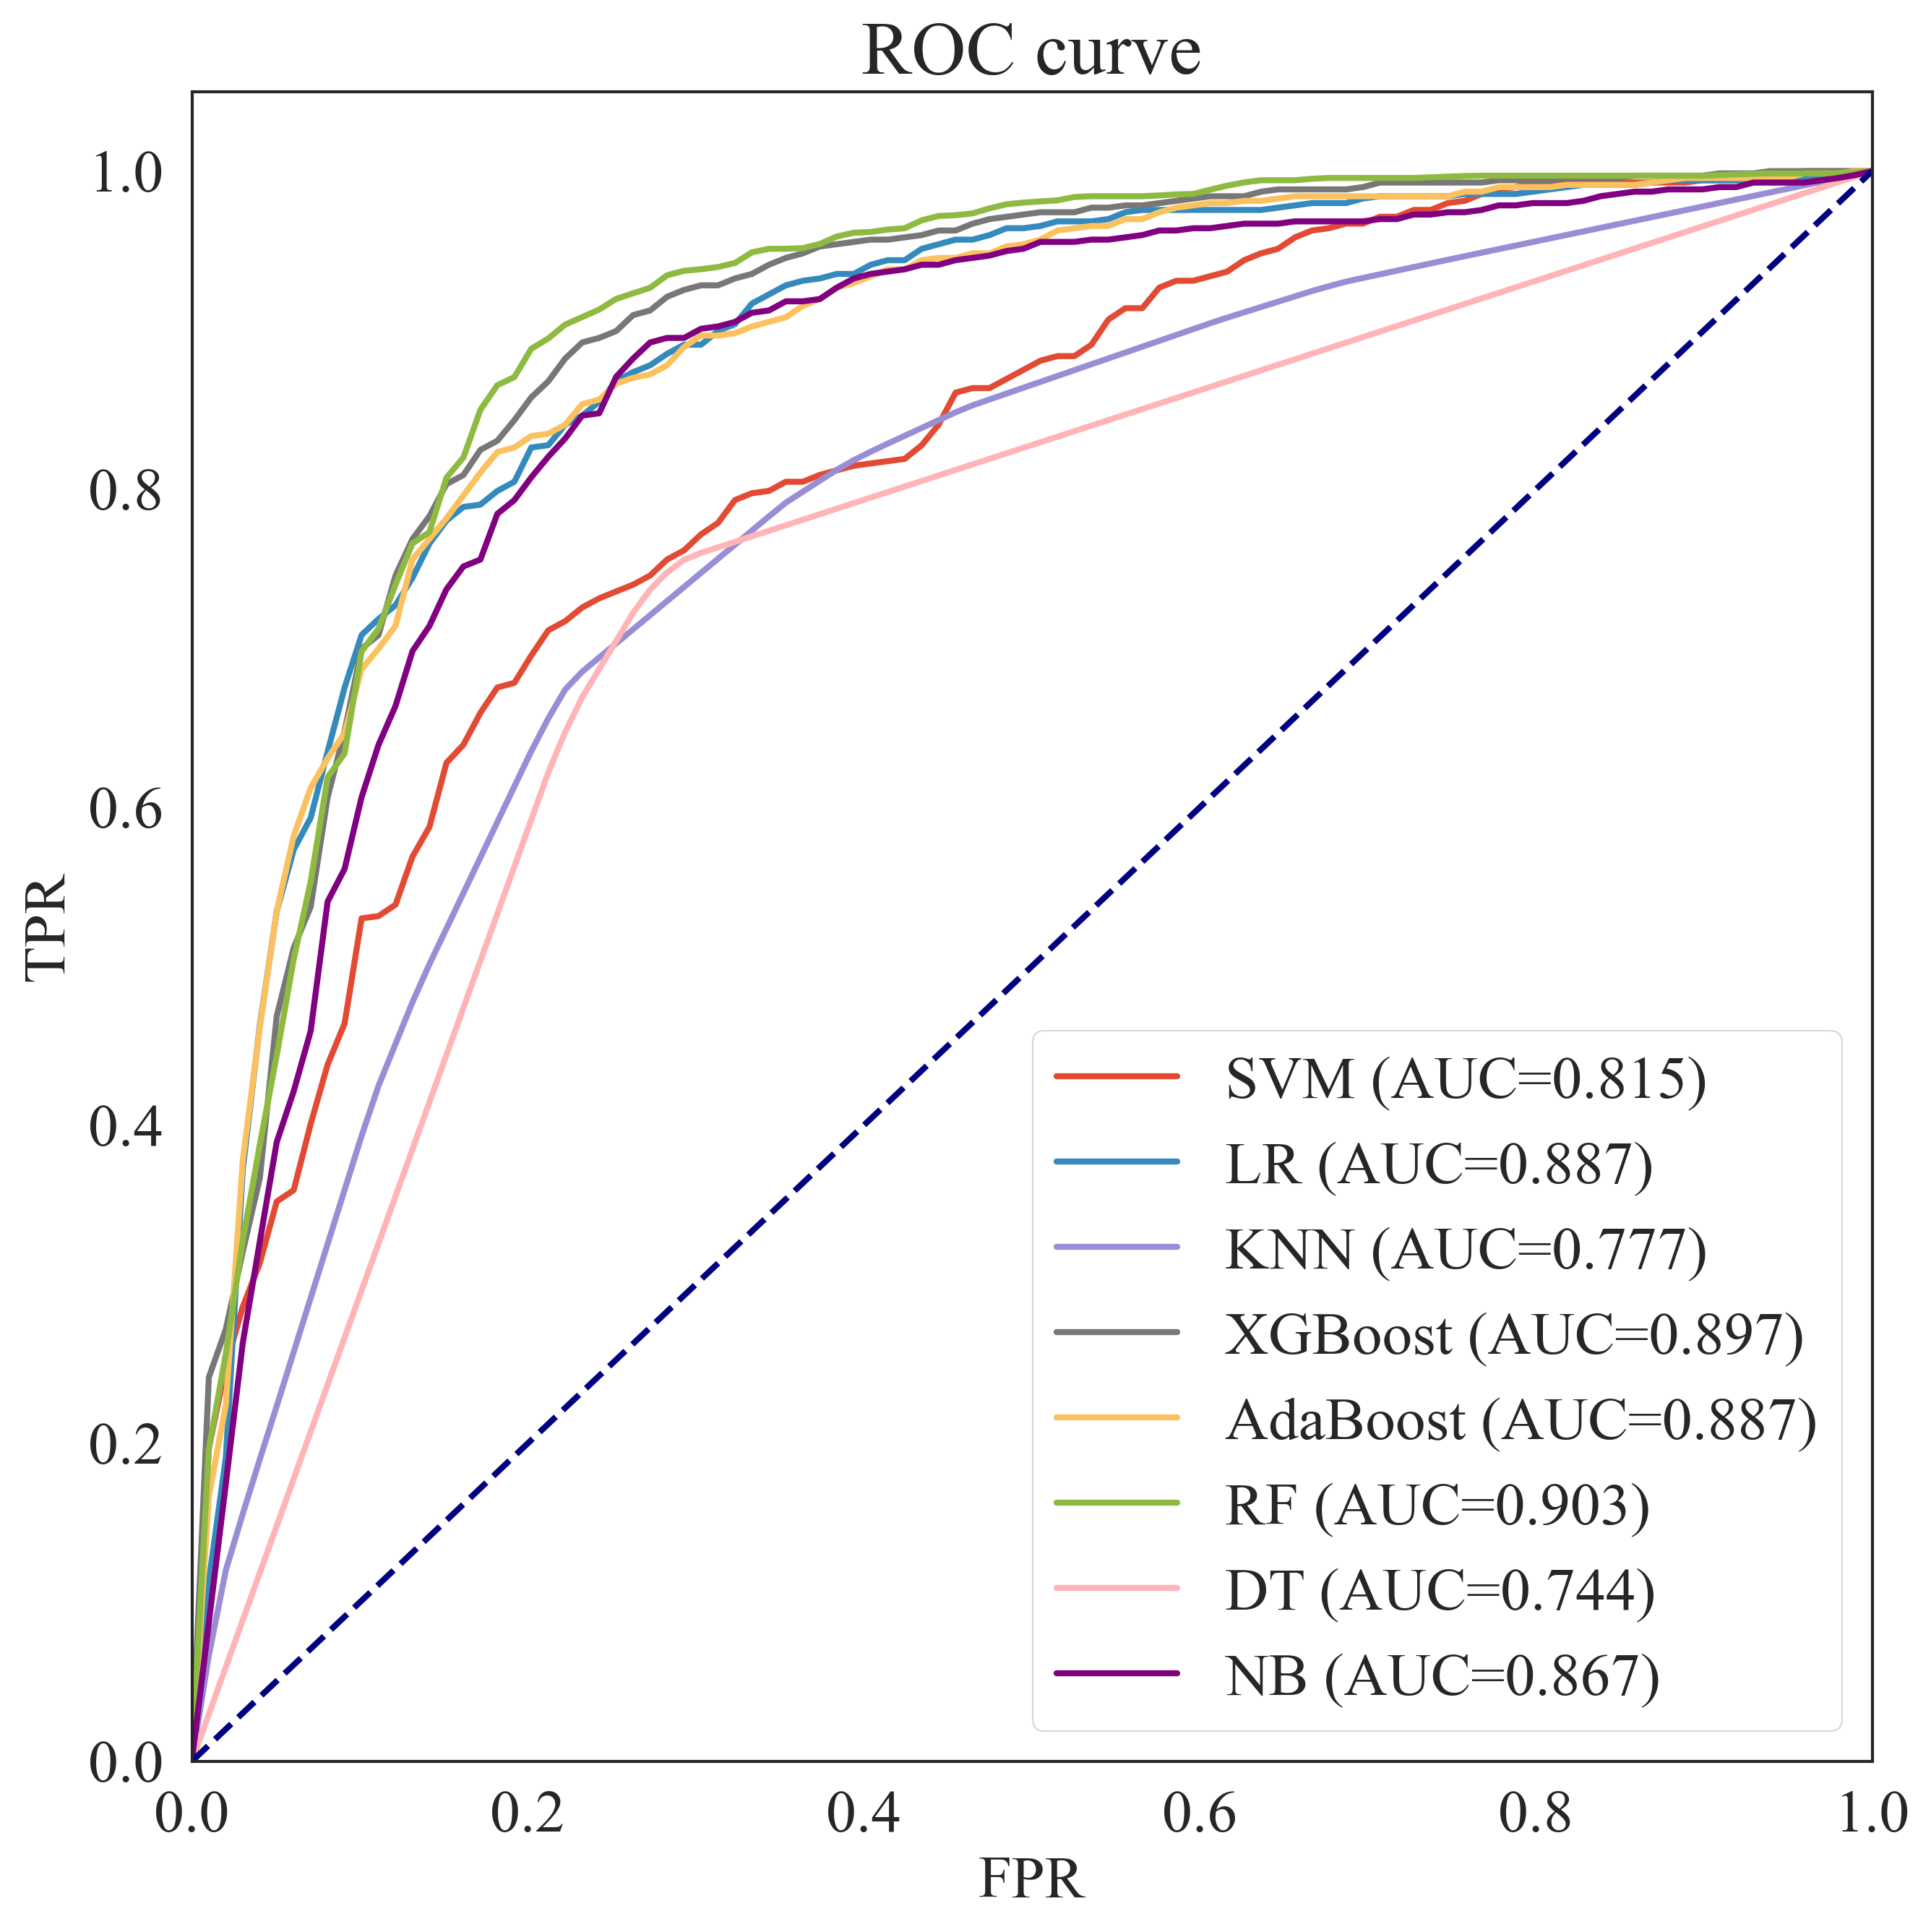

In [30]:
#5. 构建模型，画roc图，挑选性能最好的模型
import seaborn as sns
# theme = plt.get_cmap('tab20')
#sns.set_style("white")
plt.style.use('ggplot')
sns.set_style('white')

plt.figure(figsize=(10, 10),dpi=300,facecolor='white')
List2 = ['SVM','LR', 'KNN','XGBoost', 'AdaBoost', 'RF','DT', 'NB']
plt.rcParams['font.sans-serif'] = ['Times New Roman']  # 黑体

KF = StratifiedKFold(n_splits = 5,random_state=SEED,shuffle=True)

for index in [0,1,2,3,4,5,6,7]:
    if index == 0:
        model = SVC(probability=True)
    elif index == 1:
        model = LogisticRegression(C=0.05,max_iter=10000)
    elif index == 2:
        model = KNeighborsClassifier()
    elif index == 3:
        model = XGBClassifier(random_state=SEED)
    elif index == 4:
        model = AdaBoostClassifier(random_state=SEED)
    elif index == 5:
        model = RandomForestClassifier(random_state=SEED)
    elif index == 6:
        model = DecisionTreeClassifier(random_state=SEED)
    elif index == 7:
        model = GaussianNB()
    tprs=[]
    mean_fpr=np.linspace(0,1,100)
    aucs = []
    for train_index,test_index in KF.split(X_train_UnS,y_train_UnS):
        X_train_KF,X_test_KF = X_train_UnS.loc[train_index],X_train_UnS.loc[test_index]
        Y_train_KF,Y_test_KF = y_train_UnS[train_index],y_train_UnS[test_index]
        X_train_KF_scaled,Y_train_KF_scaled = SMOTE(sampling_strategy='auto', random_state=SEED).fit_resample(X_train_KF, Y_train_KF)
        model.fit(X_train_KF_scaled,Y_train_KF_scaled)
        # model.fit(X_train_KF,Y_train_KF)
        Y_score = model.predict_proba(X_test_KF)[:,1]
        fpr,tpr,thresholds=roc_curve(Y_test_KF,Y_score)
        tprs.append(interp(mean_fpr,fpr,tpr))
        tprs[-1][0]=0.0
        AUROC = auc(fpr,tpr)
        aucs.append(AUROC)
    mean_tpr=np.mean(tprs,axis=0)
    mean_tpr[-1]=1.0
    mean_auc=np.mean(aucs)
    if index == 7:
        plt.plot(mean_fpr, mean_tpr, color='purple',linewidth=2,label = List2[index]+" (AUC="+str(round(mean_auc, 3))+")")
    else:
        plt.plot(mean_fpr, mean_tpr,linewidth=2,label = List2[index]+" (AUC="+str(round(mean_auc, 3))+")")

plt.plot([0, 1], [0, 1], color='navy', linewidth=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=20)
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=20)
plt.xlabel('FPR', fontsize=20)
plt.ylabel('TPR', fontsize=20)
plt.title('ROC curve', fontsize=25)
plt.legend(loc="lower right", fontsize=20)
plt.savefig('roc_curve.jpg',)
plt.show()

In [31]:
#5. 定义计算准确率、特异性等的函数
def evalution(y_test,y_pred,y_score):
    conf = confusion_matrix(y_test, y_pred)
    acc = (conf[0, 0] + conf[1, 1]) / (conf[0, 0] + conf[0, 1] + conf[1, 0] + conf[1, 1])
    TPR = (conf[1, 1]) / (conf[1, 0] + conf[1, 1])
    FPR = (conf[0, 1]) / (conf[0, 0] + conf[0, 1])
    TNR = (conf[0, 0]) / (conf[0, 0] + conf[0, 1])
    FNR = (conf[1, 0]) / (conf[1, 0] + conf[1, 1])
    if conf[0, 1] + conf[1, 1] == 0:
        PPV = 0
    else:
        PPV = (conf[1, 1]) / (conf[0, 1] + conf[1, 1])
    if conf[0, 0] + conf[1, 0] == 0:
        NPV = 0
    else:
        NPV = (conf[0, 0]) / (conf[0, 0] + conf[1, 0])
    if PPV + TPR == 0:
        F1 = 0
    else:
        F1 = (2 * PPV * TPR) / (PPV + TPR)
    #y_score = model.predict_proba(X_test)[:, 1]
    fpr1, tpr1, threshold1 = roc_curve(y_test, y_score)
    AUROC = auc(fpr1, tpr1)
    precision2, recall2, thresholds2 = precision_recall_curve(y_test, y_score)
    AUPRC = auc(recall2, precision2)
    scores_dict = {
        '准确率': round(acc, 5),
        '敏感性':round(TPR, 5),
        '特异性':round(TNR, 5),'精确率': round(PPV, 5),
        'F1分数': round(F1, 5),
        'AUROC' : round(AUROC, 5),'AUPRC':round(AUPRC, 5)
    }
    return scores_dict



In [36]:
#delong检验
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as st
from sklearn import metrics

class DelongTest():
    def __init__(self,preds1,preds2,label,threshold=0.05):
        '''
        preds1:the output of model1
        preds2:the output of model2
        label :the actual label
        '''
        self._preds1=preds1
        self._preds2=preds2
        self._label=label
        self.threshold=threshold
        self._show_result()
        self.__str__()

    def _auc(self,X, Y)->float:
        return 1/(len(X)*len(Y)) * sum([self._kernel(x, y) for x in X for y in Y])

    def _kernel(self,X, Y)->float:
        '''
        Mann-Whitney statistic
        '''
        return .5 if Y==X else int(Y < X)

    def _structural_components(self,X, Y)->list:
        V10 = [1/len(Y) * sum([self._kernel(x, y) for y in Y]) for x in X]
        V01 = [1/len(X) * sum([self._kernel(x, y) for x in X]) for y in Y]
        return V10, V01

    def _get_S_entry(self,V_A, V_B, auc_A, auc_B)->float:
        return 1/(len(V_A)-1) * sum([(a-auc_A)*(b-auc_B) for a,b in zip(V_A, V_B)])
    
    def _z_score(self,var_A, var_B, covar_AB, auc_A, auc_B):
        return (auc_A - auc_B)/((var_A + var_B - 2*covar_AB )**(.5)+ 1e-8)

    def _group_preds_by_label(self,preds, actual)->list:
        X = [p for (p, a) in zip(preds, actual) if a]
        Y = [p for (p, a) in zip(preds, actual) if not a]
        return X, Y

    def _compute_z_p(self):
        X_A, Y_A = self._group_preds_by_label(self._preds1, self._label)
        X_B, Y_B = self._group_preds_by_label(self._preds2, self._label)

        V_A10, V_A01 = self._structural_components(X_A, Y_A)
        V_B10, V_B01 = self._structural_components(X_B, Y_B)

        auc_A = self._auc(X_A, Y_A)
        auc_B = self._auc(X_B, Y_B)

        # Compute entries of covariance matrix S (covar_AB = covar_BA)
        var_A = (self._get_S_entry(V_A10, V_A10, auc_A, auc_A) * 1/len(V_A10)+ self._get_S_entry(V_A01, V_A01, auc_A, auc_A) * 1/len(V_A01))
        var_B = (self._get_S_entry(V_B10, V_B10, auc_B, auc_B) * 1/len(V_B10)+ self._get_S_entry(V_B01, V_B01, auc_B, auc_B) * 1/len(V_B01))
        covar_AB = (self._get_S_entry(V_A10, V_B10, auc_A, auc_B) * 1/len(V_A10)+ self._get_S_entry(V_A01, V_B01, auc_A, auc_B) * 1/len(V_A01))

        # Two tailed test
        z = self._z_score(var_A, var_B, covar_AB, auc_A, auc_B)
        p = st.norm.sf(abs(z))*2

        return z,p
    
    def _show_result(self):
        z,p=self._compute_z_p()
        print(f"z score = {z:.5f};\np value = {p:.5f};")
        if p < self.threshold :print("There is a significant difference")
        else:        print("There is NO significant difference")

    def __str__(self):
        z,p=self._compute_z_p()
        return str(round(p,5))

In [32]:
def cross_valid_scores(model,X,y,num_splits):
    SKF = StratifiedKFold(n_splits=num_splits,random_state=SEED,shuffle=True)
    accs = []
    TPRS = []
    TNRS = []
    PPVS = []
    All_F1 = []
    AUROCS = []
    AUPRCS = []
    scores_list = []
    for train_index,test_index in SKF.split(X,y):
        X_train_KF,X_test_KF = X.loc[train_index],X.loc[test_index]
        Y_train_KF,Y_test_KF = y[train_index],y[test_index]
        X_train_KF_scaled,Y_train_KF_scaled = SMOTE(sampling_strategy='auto', random_state=SEED).fit_resample(X_train_KF, Y_train_KF)
        model.fit(X_train_KF_scaled,Y_train_KF_scaled)
        # model.fit(X_train_KF,Y_train_KF)
        y_pred_KF = model.predict(X_test_KF)
        y_score_KF = model.predict_proba(X_test_KF)[:,1]
        scores_dict =  evalution(Y_test_KF,y_pred_KF,y_score_KF)
        accs.append(scores_dict['准确率'])
        TPRS.append(scores_dict['敏感性'])
        TNRS.append(scores_dict['特异性'])
        PPVS.append(scores_dict['精确率'])
        All_F1.append(scores_dict['F1分数'])
        AUROCS.append(scores_dict['AUROC'])
        AUPRCS.append(scores_dict['AUPRC'])
    scores_list =[round(np.mean(accs),3),round(np.mean(TPRS),3),round(np.mean(TNRS),3),round(np.mean(PPVS),3),round(np.mean(All_F1),3),round(np.mean(AUROCS),3),round(np.mean(AUPRCS),3)]
    return scores_list

In [33]:
#5. 统计各种模型的灵敏度、特异性等，比较各模型的性能
model_list = ['NB','KNN','SVM','LR','DT','AdaBoost','XGBoost', 'RF']
scores_dict_all = {}
for model_item in model_list:
    if model_item == 'NB':
        model = GaussianNB()
    elif 'KNN' == model_item:    
        model = KNeighborsClassifier()
    elif 'SVM'  == model_item:
        model = SVC(probability=True)
    elif 'LR'  == model_item:
        model = LogisticRegression(C=0.05,max_iter=10000)
    elif 'DT'  == model_item:    
        model = DecisionTreeClassifier(random_state=SEED)   
    elif 'AdaBoost'  == model_item:    
        model = AdaBoostClassifier(random_state=SEED)
    elif 'XGBoost'  == model_item:    
        model = XGBClassifier(
           random_state=SEED
                             )
    elif 'RF'  == model_item:    
        model = RandomForestClassifier(random_state=SEED)
    scores_dict_all[model_item] = cross_valid_scores(model,X_train_UnS,y_train_UnS,5)
    
results_image_score = pd.DataFrame(list(scores_dict_all.values()),index=list(scores_dict_all.keys()),columns=['准确率','敏感性','特异性','精确率','F1分数','AUROC','AUPRC'])
results_image_score.to_csv('image_score.csv')


In [34]:
#6. 随机森林查看各特征的重要程度
def feature_importance(model,X,y,filename,figname,fontype,fontsize):
    col_labels = X.columns
    model.fit(X, y)
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    importances_feature = {}
    for f in range(X.shape[1]):
        importance = "%2d) %-*s %f" % (f+1,30,col_labels[indices[f]], importances[indices[f]])
        importances_feature[col_labels[indices[f]]] = round(importances[indices[f]],6)
        print(importance)
    FeatureList = importances_feature.keys()
    valuelist = importances_feature.values()
    rows = zip(FeatureList,valuelist)
    with open(filename,'w',newline='') as out:
        writer = csv.writer(out)
        for row in rows:
            writer.writerow(row)
    plt.figure(figsize=[10, 5],facecolor='white',dpi=300)
    plt.rcParams['font.sans-serif'] = [fontype]
    plt.rcParams['axes.unicode_minus'] = False
    plt.bar(range(X.shape[1]),importances[indices],align='center',color='steelblue')
    plt.xlim([-1,X.shape[1]])
    plt.xticks(range(X.shape[1]),col_labels[indices],rotation=90, fontsize=fontsize)
    # plt.yticks(fontsize=fontsize)
    plt.title('Feature importance of the RF model')
    plt.tight_layout()
    plt.savefig(figname)
    plt.show()
    return   FeatureList

model = RandomForestClassifier(random_state=SEED)

 1) AGE                            0.072875
 2) 白蛋白-加                          0.050444
 3) 脉搏                             0.048476
 4) 中性粒细胞与淋巴细胞比值                   0.047242
 5) 冠心病                            0.040298
 6) 国际标准化比率                        0.040110
 7) 血压Low                          0.039052
 8) 中性粒细胞绝对值                       0.037672
 9) 中性粒细胞百分比                       0.034121
10) 凝血酶原时间                         0.032262
11) eGFR                           0.030639
12) 血压high                         0.030061
13) 肌酐-加                           0.029854
14) BMI                            0.026175
15) 总蛋白-加                          0.026027
16) 白细胞计数                          0.025127
17) 严重贫血                           0.023636
18) 平均血红蛋白浓度                       0.020334
19) 淋巴细胞绝对值                        0.019417
20) 钙-加                            0.018314
21) 部分凝血活酶时间                       0.017830
22) 呼吸                             0.016681
23) 心肌梗死                        

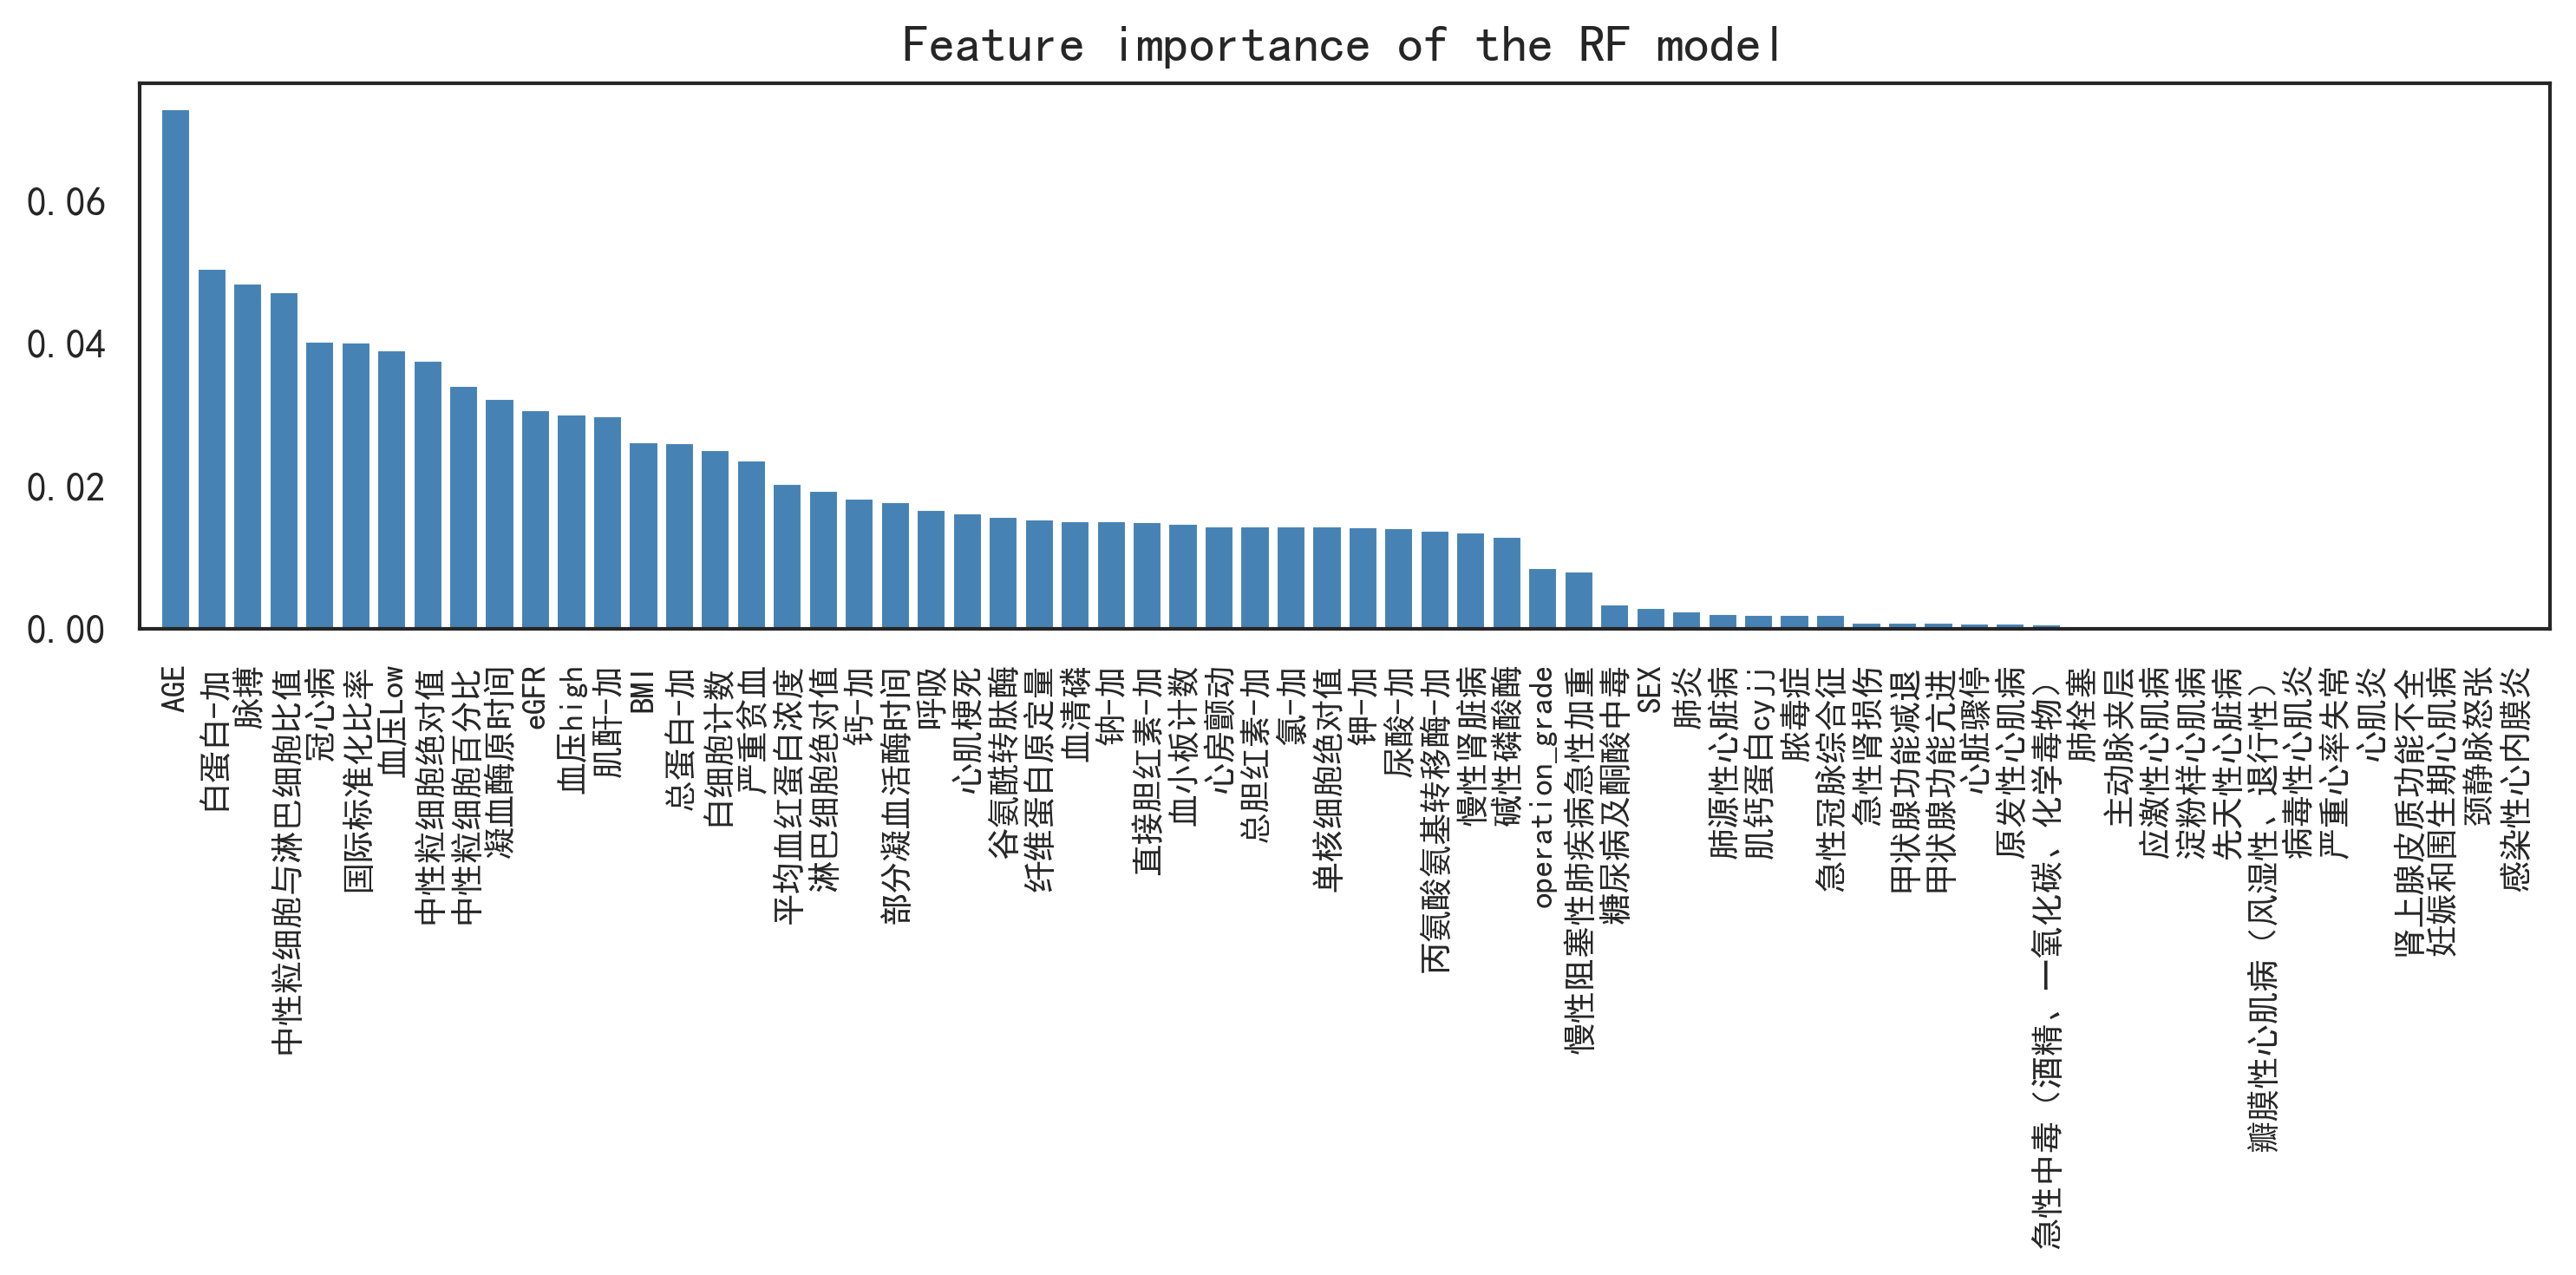

In [35]:
X_train_UnS_scaled,y_train_UnS_scaled = SMOTE(sampling_strategy='auto', random_state=SEED).fit_resample(X_train_UnS, y_train_UnS)
FeatureList = feature_importance(model,X_train_UnS_scaled,y_train_UnS_scaled,'RF_importance.csv','RF_feature.png','SimHei',9)

 1) Age                            0.072875
 2) Albumin                        0.050444
 3) Pulse                          0.048476
 4) NLR                            0.047242
 5) Coronary heart disease         0.040298
 6) INR                            0.040110
 7) Diastolic blood pressure       0.039052
 8) Absolute neutrophil count      0.037672
 9) Neutrophil percentage          0.034121
10) Prothrombin time               0.032262
11) eGFR                           0.030639
12) Systolic blood pressure        0.030061
13) Serum creatinine               0.029854
14) BMI                            0.026175
15) Total protein                  0.026027
16) White blood cell count         0.025127
17) Severe anemia                  0.023636
18) MCHC                           0.020334
19) Absolute lymphocyte count      0.019417
20) Calcium                        0.018314
21) APTT                           0.017830
22) Respiratory rate               0.016681
23) Myocardial infarction       

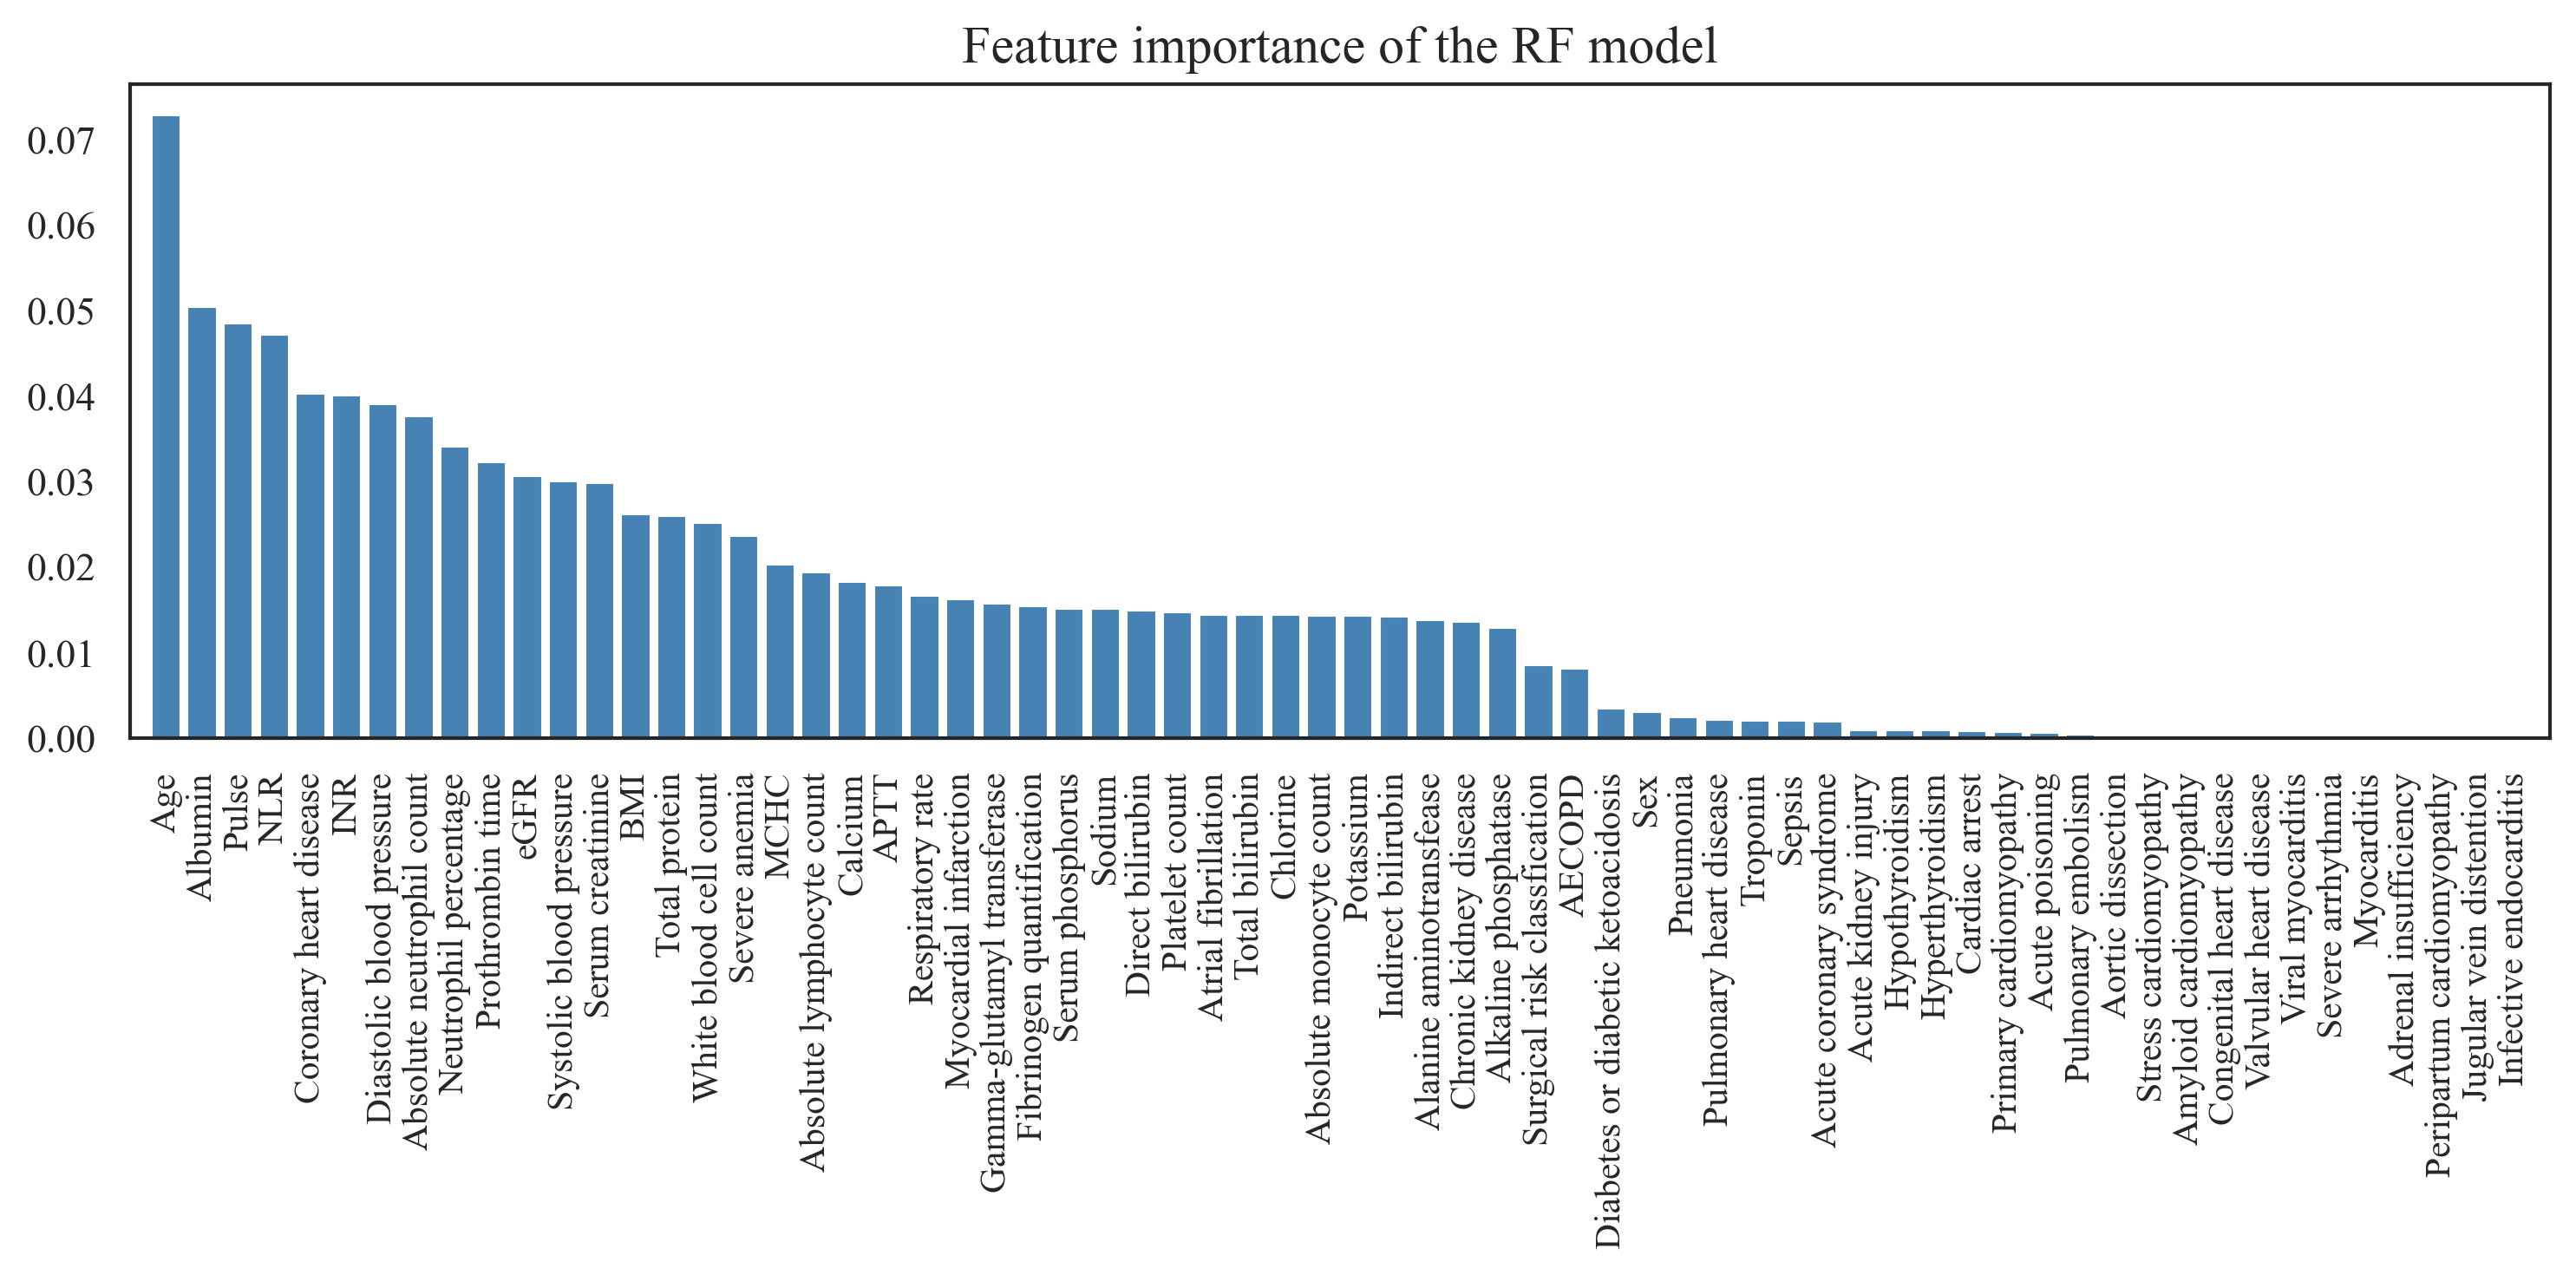

In [36]:
X_train_UnS_scaled_EN = X_train_UnS_scaled.rename(columns=dict_name)
# X_train_UnS_EN = X_train_UnS.rename(columns=dict_name)
FeatureList_EN = feature_importance(model,X_train_UnS_scaled_EN,y_train_UnS_scaled,'RF_importance_EN.csv',
'RF_feature_EN.png','Times New Roman',10)

In [129]:
# # 6.shap解释特征的重要性
# col_labels = X_train_UnS.columns
# model = RandomForestClassifier(random_state=SEED)
# model.fit(X_train_UnS, y_train_UnS)
# # 创建SHAP解释器
# explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(X_test)[1]
# # 计算特征重要性
# shap_importance = np.abs(shap_values).mean(axis=0)

# # 将特征重要性与特征名称关联
# feature_importance_df = pd.DataFrame({
#     'Feature': col_labels,
#     'Importance': shap_importance
# })

# # 按特征重要性排序
# sorted_feature_importance = feature_importance_df.sort_values(by='Importance', ascending=False)

# # 输出排序后的特征重要性
# print(sorted_feature_importance)
# # sorted_feature_importance.to_csv('feature_importance_shap_train.csv')
# sorted_feature_importance.to_csv('feature_importance_shap_test.csv')

     Feature  Importance
60     白蛋白-加    0.057553
1        AGE    0.049728
59     总蛋白-加    0.028540
56       钙-加    0.027379
62      eGFR    0.024159
..       ...         ...
28       心肌炎    0.000000
49  肌钙蛋白cyjj    0.000000
47      心脏骤停    0.000000
30    应激性心肌病    0.000000
6     原发性心肌病    0.000000

[69 rows x 2 columns]


32 0.903


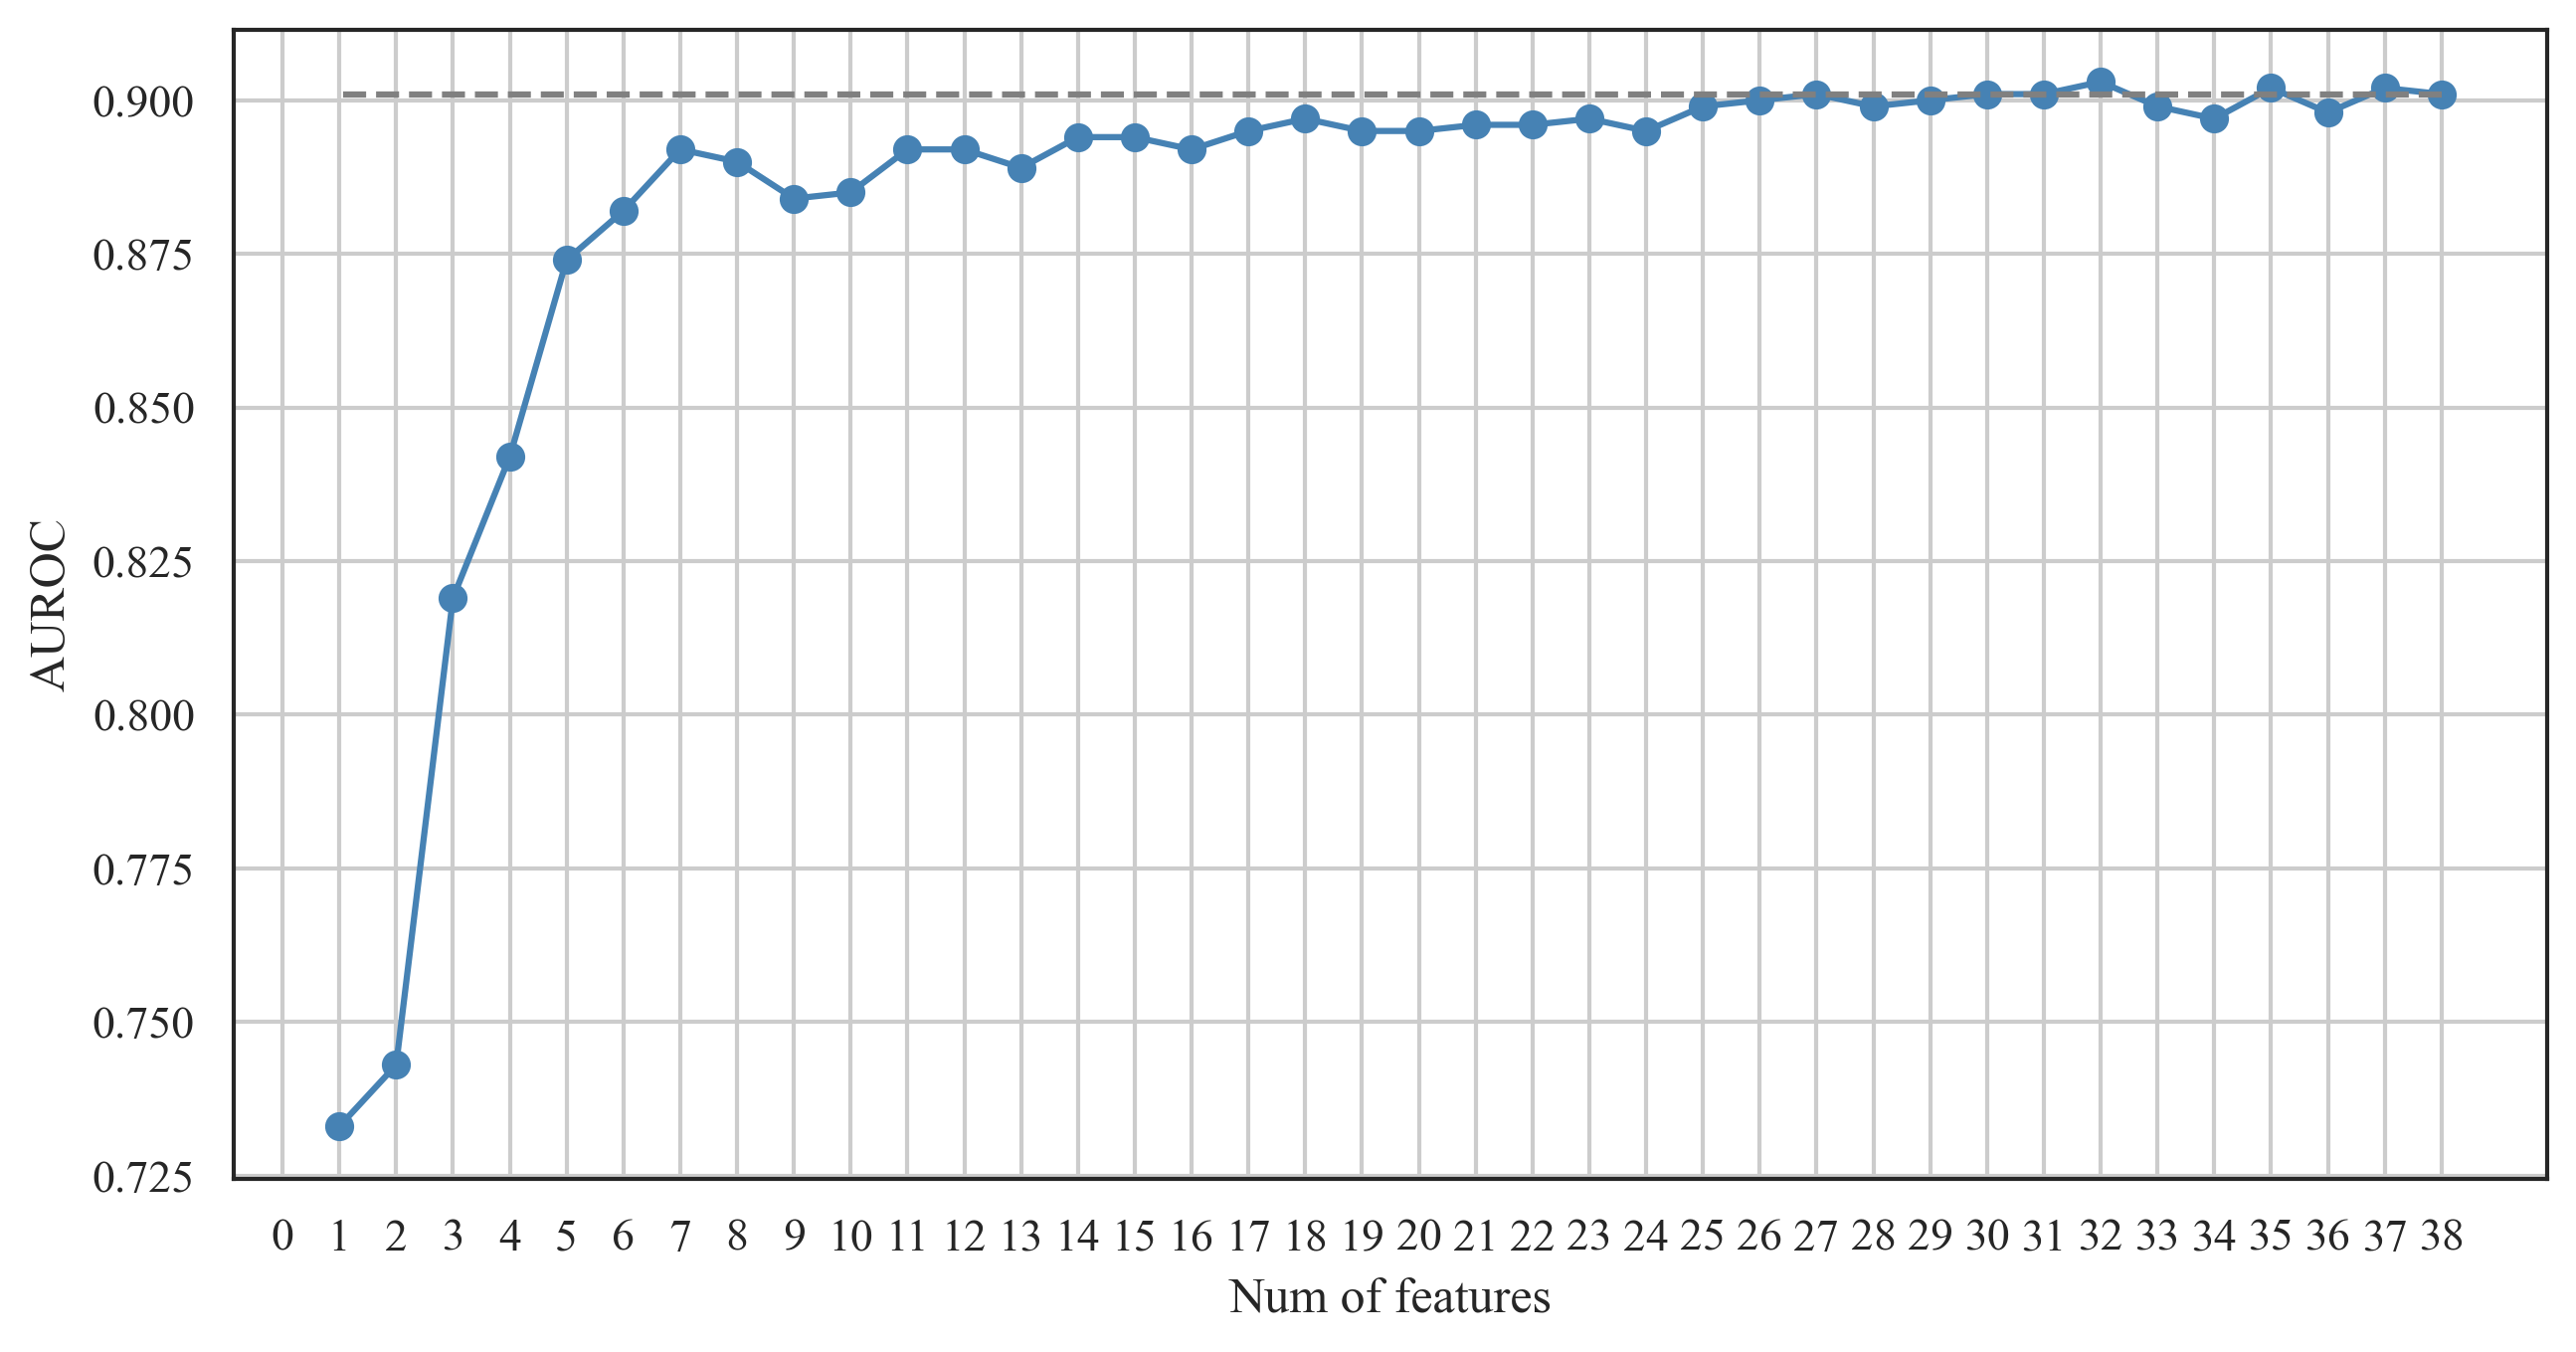

In [37]:
#7.手动特征选择，按照随机森林特征重要性的排序，一个一个扔掉不重要的特征，5折交叉验证
def remove_feature_performance(model,X,y,num_splits,FeatureList):
    FeaImpList =  list(FeatureList)
    scores_dict_ALL = {}
    # scores_dict_ALL[len(FeaImpList)] = list(results_image_score.loc[modelname])
    
    for i in range(0,len(FeaImpList),1):
        if i == 0:
            X_new = X[FeaImpList]
            scores_dict_ALL[len(FeaImpList)] = cross_valid_scores(model,X_new,y,num_splits)
        else:
            FeaImpList.pop()
            X_new = X[FeaImpList]
            scores_dict_ALL[len(FeaImpList)] = cross_valid_scores(model,X_new,y,num_splits)

    key_List = list(scores_dict_ALL.keys())
    key_str = list(map(str,key_List))
    results = pd.DataFrame(list(scores_dict_ALL.values()),index=key_str,columns=['准确率','敏感性','特异性','精确率','F1分数','AUROC','AUPRC'])
    results.to_csv('image_score_RemFtr.csv')

    dict_roc = list(results['AUROC'])
    num = len(list(FeatureList))
    max_value = max(dict_roc)
    max_index = dict_roc.index(max_value)
    print(key_str[max_index],max_value)
    fig=plt.figure(figsize=[10, 5],facecolor='white',dpi=300)
    plt.plot(key_List, dict_roc,'-',linewidth=1.5,color='steelblue')
    plt.plot(key_List, dict_roc,'o',color='steelblue')
    plt.plot(key_List,[dict_roc[0]]*num, '--' ,color='grey' )
    plt.xlabel('Num of features')
    plt.ylabel('AUROC')
    plt.xticks(range(0,(num+1),1))
    plt.grid()
    plt.savefig('remove_feature.png')
    plt.show()
    return

model = RandomForestClassifier(random_state=SEED)
FeatureList = list(FeatureList)[0:38:1]
remove_feature_performance(model,X_train_UnS,y_train_UnS,5,FeatureList)

In [77]:
fig_data = pd.read_csv('image_score_RemFtr_fig.csv',encoding='GB18030')
fig_data.head()

Number  AUROC  Accuracy  Sensitivity  Specificity  Precision  F1 score
0      38  0.901     0.833        0.859        0.806      0.816     0.837
1      33  0.899     0.833        0.865        0.800      0.813     0.838
2      28  0.899     0.829        0.848        0.810      0.818     0.832
3      23  0.897     0.829        0.852        0.806      0.816     0.833
4      18  0.897     0.830        0.851        0.810      0.819     0.834

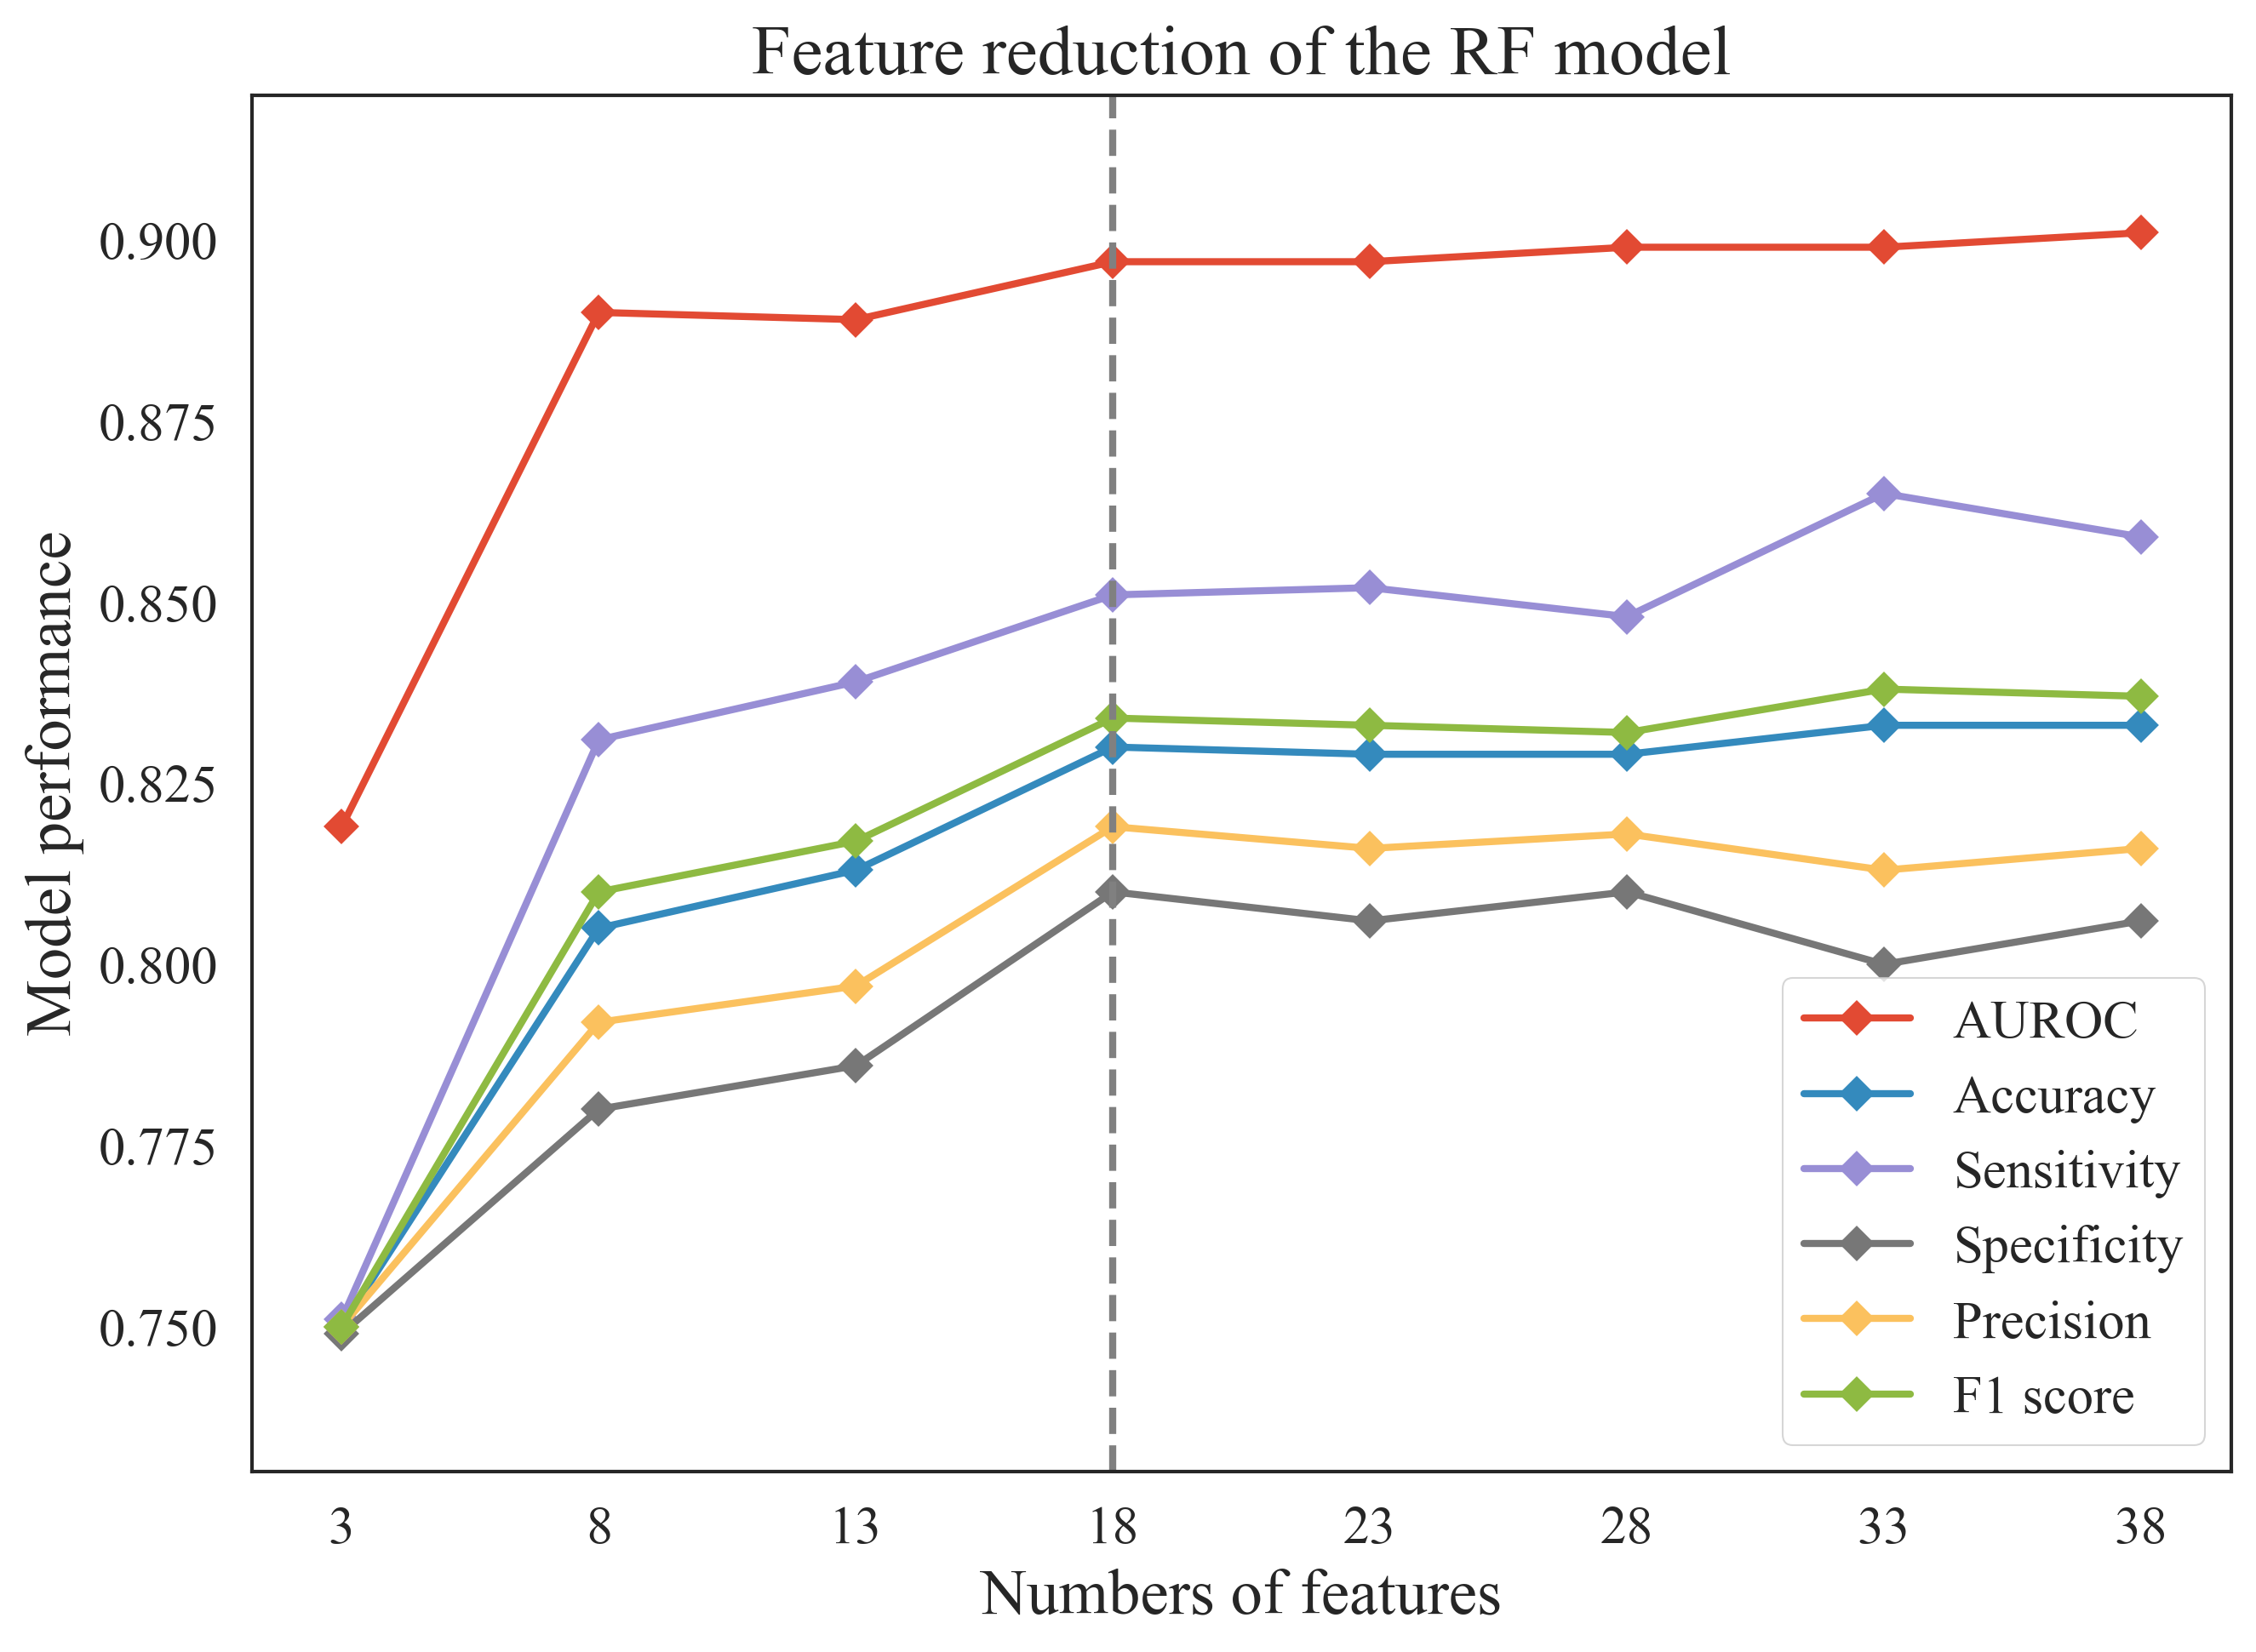

In [82]:
plt.style.use('ggplot')
sns.set_style('white')
plt.figure(figsize=[10, 7],facecolor='white',dpi=300)
plt.rcParams['font.sans-serif'] = ['Times New Roman']
for i in range(1,fig_data.shape[1]):
    label = fig_data.columns[i]
    plt.plot(fig_data['Number'],fig_data.iloc[:,i],marker='D',linewidth=2,label=label)

plt.axvline(18,linewidth=2,linestyle='--' ,color='grey' )
# plt.xlim()
plt.ylim([0.73,0.92])
plt.xticks([3,8,13,18,23,28,33,38],fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Numbers of features',fontsize=18)
plt.ylabel('Model performance',fontsize=18)
plt.title('Feature reduction of the RF model',fontsize=20)
plt.legend(loc="lower right", fontsize=15)
plt.savefig('remove_feature_EN.png')
plt.show()

In [41]:
featureList = list(FeatureList)[0:18:1] 

In [42]:
featureList

['AGE',
 '白蛋白-加',
 '脉搏',
 '中性粒细胞与淋巴细胞比值',
 '冠心病',
 '国际标准化比率',
 '血压Low',
 '中性粒细胞绝对值',
 '中性粒细胞百分比',
 '凝血酶原时间',
 'eGFR',
 '血压high',
 '肌酐-加',
 'BMI',
 '总蛋白-加',
 '白细胞计数',
 '严重贫血',
 '平均血红蛋白浓度']

In [45]:
featureList = list(FeatureList)[0:18:1] 
featureList.remove('总蛋白-加')
featureList.remove('中性粒细胞百分比')
featureList.remove('中性粒细胞绝对值')
# featureList.remove('钙-加')
featureList.remove('凝血酶原时间')

In [46]:
# featureList.remove('血清磷')
# featureList.remove('谷氨酰转肽酶')
# featureList.remove('BMI')
# featureList = list(FeatureList)[0:15:1]   #取手动循环的最佳特征组合
# featureList = [ n for n in sfs.k_feature_names_] #取SFS的最佳特征组合
X_train_UnS_new = X_train_UnS[featureList]
X_test_new = X_test[featureList]
X_train_UnS_new.head()

AGE  白蛋白-加     脉搏  中性粒细胞与淋巴细胞比值  冠心病  国际标准化比率  血压Low     eGFR  血压high  \
0   91   39.7   76.0      2.214286    1     1.03   75.0  111.997   125.0   
1   74   39.7   60.0      2.214286    0     1.03   76.0  111.997   120.0   
2   77   29.3   82.0      6.186047    1     1.09   68.0  193.324   120.0   
3   82   23.9  101.0     17.823529    0     1.86   50.0  108.938    99.0   
4   76   30.8  110.0     22.481481    0     1.01   63.0  153.518   115.0   

   肌酐-加    BMI  白细胞计数  严重贫血  平均血红蛋白浓度  
0  73.0  24.34   6.19     1     335.0  
1  73.0  14.65   6.19     0     335.0  
2  36.9  21.64   7.03     0     324.0  
3  77.6  24.34  16.71     0     352.0  
4  58.4  17.19   6.52     0     336.0

AGE	脉搏	中性粒细胞绝对值	中性粒细胞与淋巴细胞比值	冠心病	白蛋白-加	eGFR	国际标准化比率	肌酐-加	血压Low	BMI	血压high

In [47]:
cross_valid_scores(model,X_train_UnS_new,y_train_UnS,5)

[0.833, 0.855, 0.81, 0.819, 0.836, 0.9, 0.888]

In [48]:
featureList

['AGE',
 '白蛋白-加',
 '脉搏',
 '中性粒细胞与淋巴细胞比值',
 '冠心病',
 '国际标准化比率',
 '血压Low',
 'eGFR',
 '血压high',
 '肌酐-加',
 'BMI',
 '白细胞计数',
 '严重贫血',
 '平均血红蛋白浓度']

In [26]:
# X_train_scaled = X_train_scaled_new
# X_test = X_test_new
# X_train = X_train[featureList]
# print(X_train_scaled.shape)
# print(X_test.shape)

(1600, 12)
(273, 12)


In [49]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
def plot_ROC(model,X_train,y_train,X_test,y_test,figname):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    y_scores = model.predict_proba(X_test)[:,1]
    acc = accuracy_score(y_test, y_pred) # 准确率acc
    cm = confusion_matrix(y_test, y_pred) # 混淆矩阵
    cr = classification_report(y_test, y_pred) # 分类报告
    fpr, tpr, thresholds = roc_curve(y_test, y_scores) # 计算ROC曲线和AUC值,绘制ROC曲线
    roc_auc = auc(fpr, tpr)
    scores_dict =  evalution(y_test,y_pred,y_scores)
    plt.figure(figsize=(7,7),dpi=300)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.01])
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel('False positive rate',fontsize=18)
    plt.ylabel('True positive rate',fontsize=18)
    plt.title('Receiver operating characteristic curve',fontsize=20)
    plt.legend(loc="lower right",fontsize=18)
    plt.tight_layout()
    plt.savefig(figname)
    plt.show()

    print(acc)
    print(cr)
    print(scores_dict)
    return  y_pred, y_scores

In [50]:
#################################################### 画混淆矩阵 ##################################################################################################
import matplotlib.pyplot as plt
import seaborn as sns
def plot_confusion(y_test,y_pred,label_list):
    confusion = confusion_matrix(y_test,y_pred)
    label_list = label_list
    plt.figure(figsize=(7,7), dpi=300) 
    sns.heatmap(confusion,annot=True,cmap='Blues',fmt='d',xticklabels=label_list,
                yticklabels=label_list,annot_kws={'size': 15},
                # cbar_kws={"shrink": 1.1}
                )
    plt.xticks(size=15)
    plt.yticks(size=15)
    plt.xlabel('Predict',fontsize=18)
    plt.ylabel('True',fontsize=18)
    plt.title("Confusion matrix",fontdict={'weight':'normal','size': 20})
    plt.tight_layout()
    plt.savefig('confusion.png')
    plt.show()


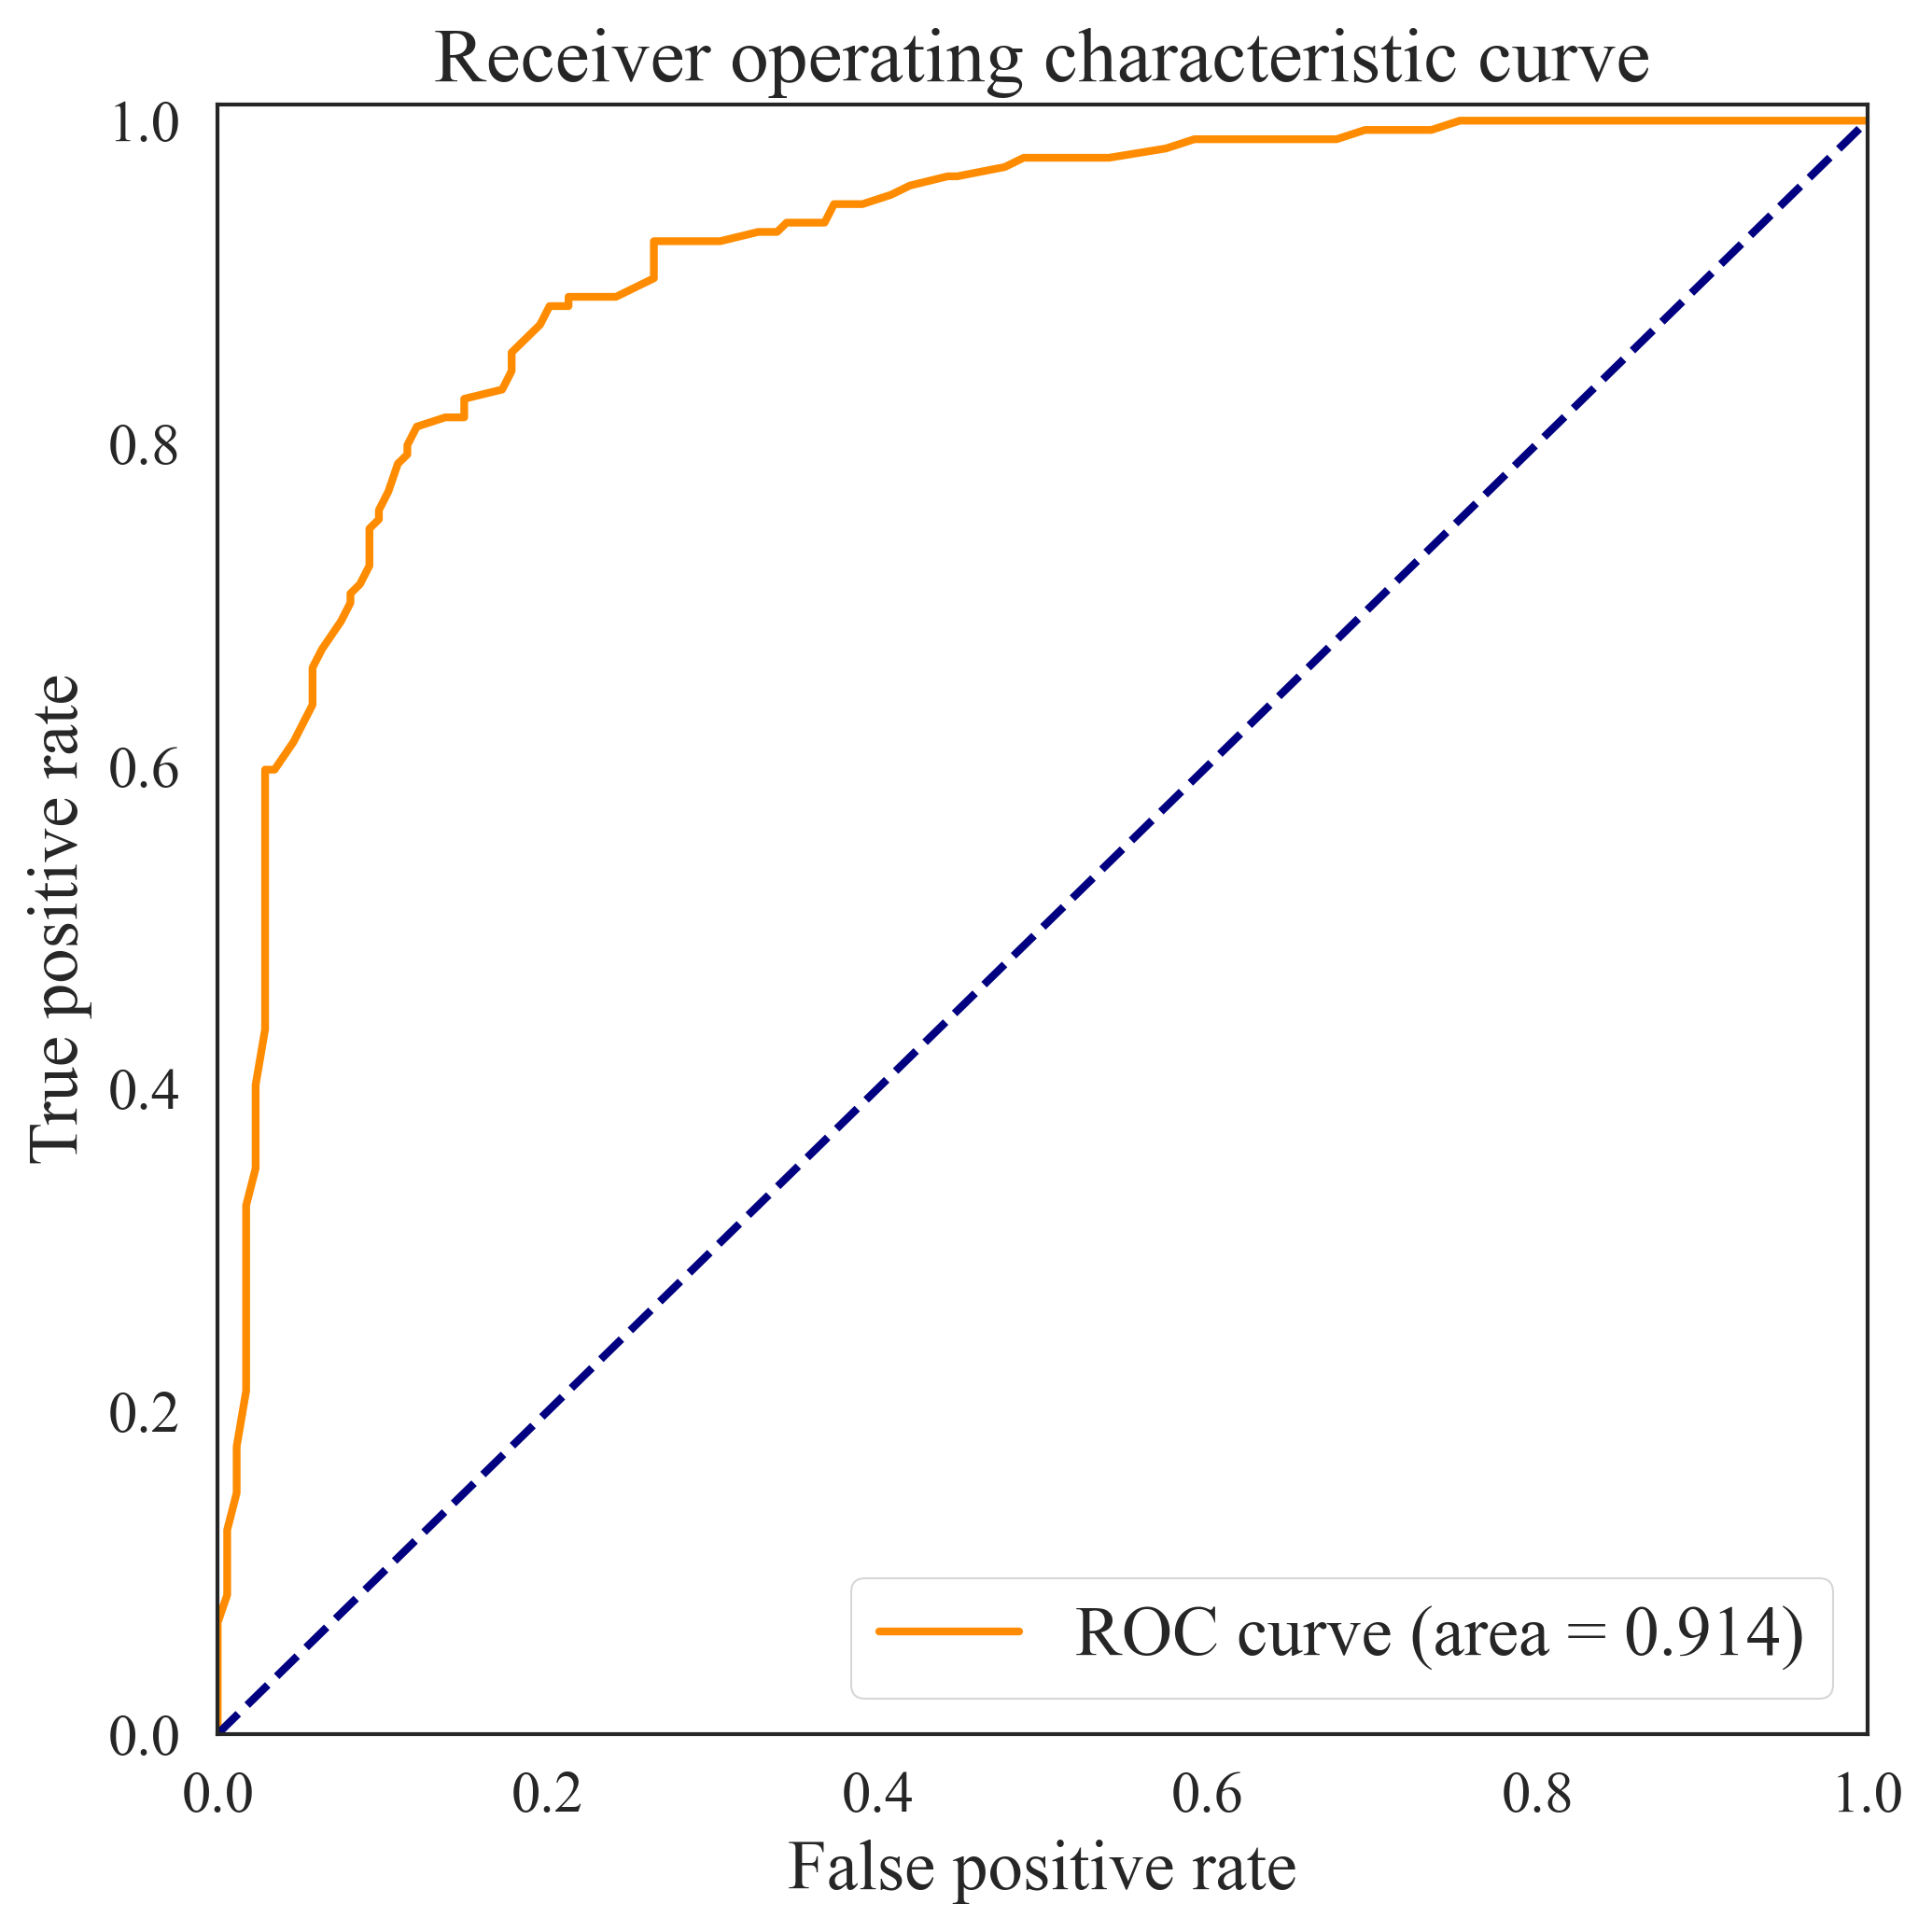

0.8362068965517241
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       174
           1       0.85      0.82      0.83       174

    accuracy                           0.84       348
   macro avg       0.84      0.84      0.84       348
weighted avg       0.84      0.84      0.84       348

{'准确率': 0.83621, '敏感性': 0.81609, '特异性': 0.85632, '精确率': 0.8503, 'F1分数': 0.83284, 'AUROC': 0.91417, 'AUPRC': 0.90326}


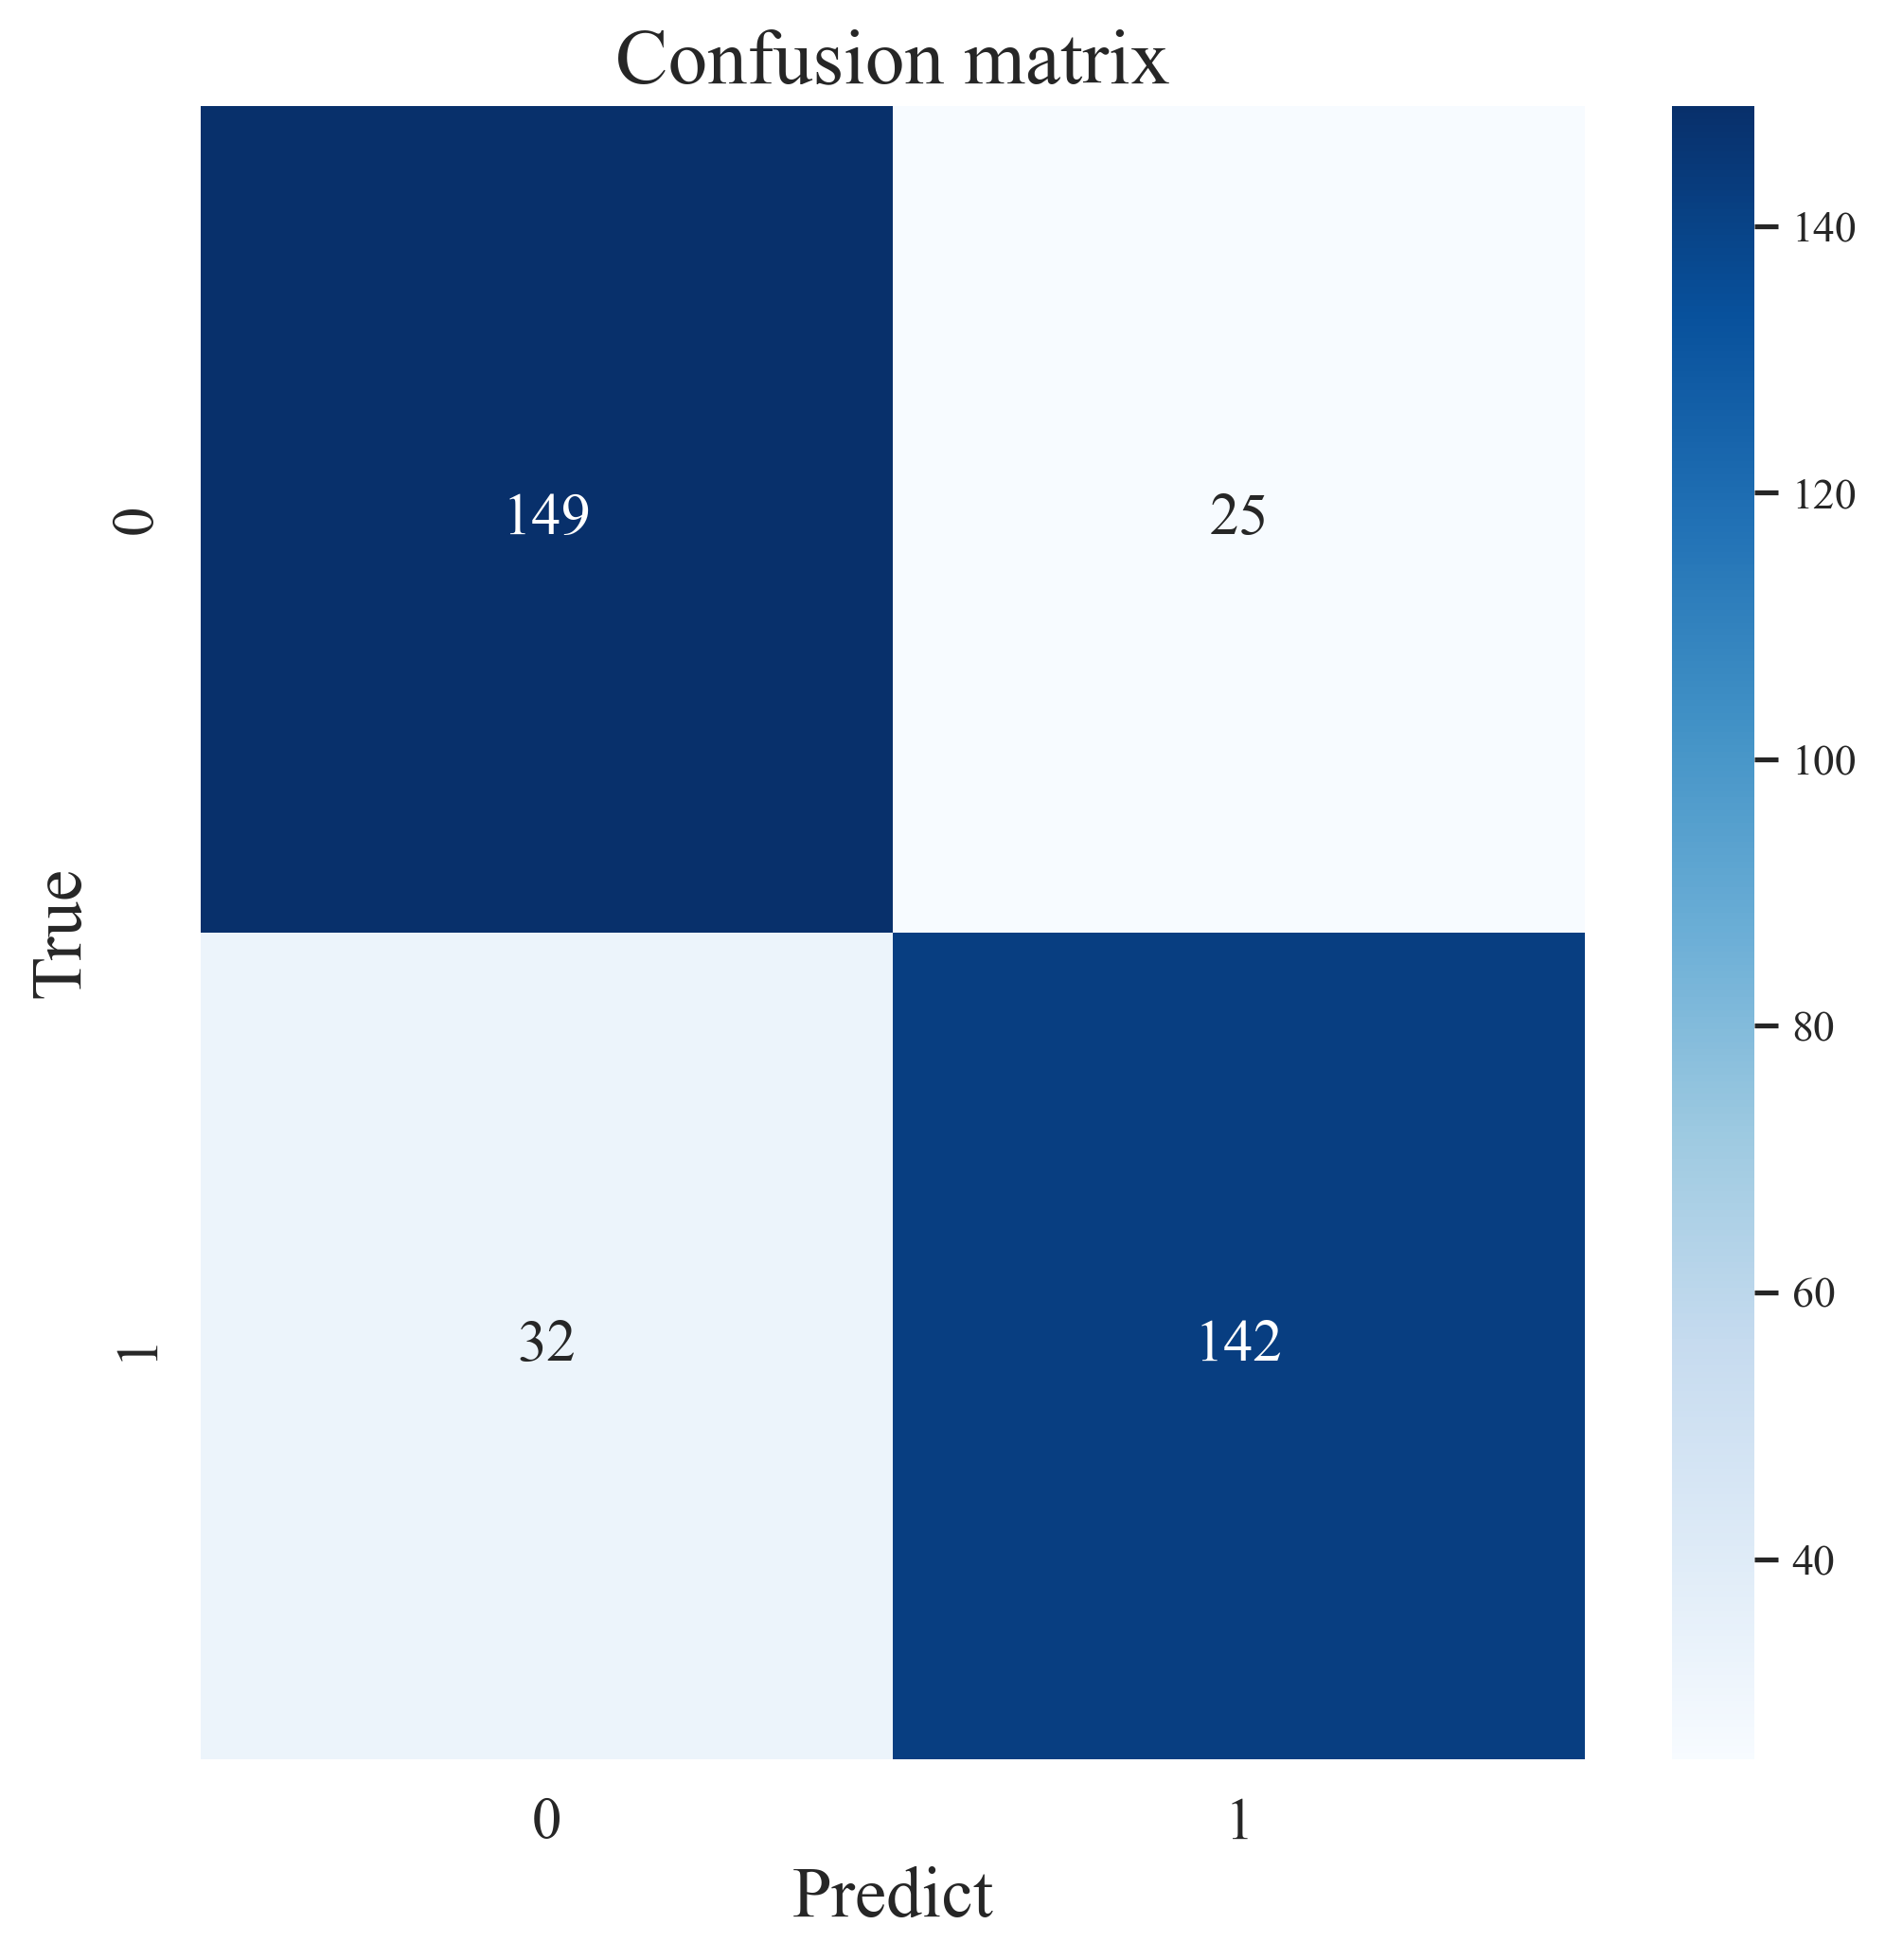

In [54]:
#筛选特征模型在测试集的验证
model = RandomForestClassifier(random_state=SEED)
X_train_UnS_new_scaled,y_train_UnS_scaled = SMOTE(sampling_strategy='auto', random_state=SEED).fit_resample(X_train_UnS_new, y_train_UnS)
y_test_pred, y_test_scores = plot_ROC(model,X_train_UnS_new_scaled,y_train_UnS_scaled,X_test_new,y_test,'Test_roc.png')
plot_confusion(y_test,y_test_pred,[0,1])

'准确率': 0.83621, '敏感性': 0.81609, '特异性': 0.85632, '精确率': 0.8503, 'F1分数': 0.83284, 'AUROC': 0.91417, 'AUPRC': 0.90326}

In [ ]:
#####################随机搜索结合网格搜索调整参数#################################
rf_model = RandomForestClassifier(random_state=SEED)
#1. 使用RandomizedSearchCV 调整超参数
#定义要调整的参数范围
param_dist = {
    'n_estimators': np.arange(100,500,10),
    'max_features': np.arange(1,6,1),
    'max_depth': np.arange(1,10,1),
    'min_samples_split': np.arange(2,10,1),
    'min_samples_leaf': np.arange(1,10,1),
    'bootstrap':[True,False]
}

random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist, n_iter=30, cv=5,verbose=2, random_state=SEED,error_score='raise')

random_search.fit(X_train_UnS_new,y_train_UnS)
print(random_search.best_params_)
print(random_search.best_score_)

In [ ]:
#####################网格搜索调整参数#################################
rf_model = RandomForestClassifier(random_state=SEED)
#1. 使用RandomizedSearchCV 调整超参数
#定义要调整的参数范围
param_dist = {
    'n_estimators': np.arange(100,500,50),
    'max_features': np.arange(1,6,2),
    'max_depth': np.arange(1,10,2),
    'min_samples_split': np.arange(2,10,2),
    'min_samples_leaf': np.arange(1,10,2),
    'bootstrap':[True,False]
}

grid_search = GridSearchCV(estimator=rf_model, param_grid = param_dist, cv=5, scoring = 'accuracy', verbose=1)

grid_search.fit(X_train_UnS_new,y_train_UnS)
print(grid_search.best_params_)
print(grid_search.best_score_)

In [52]:
#参数调整后模型的表现
# rf_final = RandomForestClassifier(n_estimators = 340, min_samples_split=5,
#                                   min_samples_leaf = 1, max_features = 3, 
#                                   max_depth = 6, bootstrap = True,
#                                   random_state=SEED)
# cross_valid_scores(rf_final,X_train_UnS_new,y_train_UnS,5)

[0.821, 0.833, 0.809, 0.814, 0.823, 0.893, 0.876]

In [55]:
rf_final = RandomForestClassifier(random_state=SEED)

In [ ]:
#最终模型在测试集的验证

# y_test_pred, y_test_scores = plot_ROC(rf_final,X_train_UnS_new_scaled,y_train_UnS_scaled,X_test_new,y_test,'Test_roc.png')
# plot_confusion(y_test,y_test_pred,[0,1])

In [99]:
def calculate_net_benefit_model(thresh_group, y_pred_score, y_label):
    net_benefit_model = np.array([])
    for thresh in thresh_group:
        y_pred_label = y_pred_score > thresh
        tn, fp, fn, tp = confusion_matrix(y_label, y_pred_label).ravel()
        n = len(y_label)
        net_benefit = (tp / n) - (fp / n) * (thresh / (1 - thresh))
        net_benefit_model = np.append(net_benefit_model, net_benefit)
    return net_benefit_model

def calculate_net_benefit_all(thresh_group, y_label):
    net_benefit_all = np.array([])
    tn, fp, fn, tp = confusion_matrix(y_label, y_label).ravel()
    total = tp + tn
    for thresh in thresh_group:
        net_benefit = (tp / total) - (tn / total) * (thresh / (1 - thresh))
        net_benefit_all = np.append(net_benefit_all, net_benefit)
    return net_benefit_all

def plot_DCA(ax, thresh_group, net_benefit_model, net_benefit_all):
    #Plot
    ax.plot(thresh_group, net_benefit_model, color = 'crimson', label = 'Model')
    ax.plot(thresh_group, net_benefit_all, color = 'black',label = 'Treat all')
    ax.plot((0, 1), (0, 0), color = 'black', linestyle = ':', label = 'Treat none')

    #Fill，显示出模型较于treat all和treat none好的部分
    y2 = np.maximum(net_benefit_all, 0)
    y1 = np.maximum(net_benefit_model, y2)
    ax.fill_between(thresh_group, y1, y2, color = 'crimson', alpha = 0.2)

    #Figure Configuration， 美化一下细节
    ax.set_xlim(0,1)
    ax.set_ylim(net_benefit_model.min() - 0.15, net_benefit_model.max() + 0.15)#adjustify the y axis limitation
    ax.tick_params(axis='both',labelsize=15)
    ax.set_xlabel(
        xlabel = 'Threshold probability', 
        fontdict= {'family': 'Times New Roman', 'fontsize': 18}
        )
    ax.set_ylabel(
        ylabel = 'Net benefit', 
        fontdict= {'family': 'Times New Roman', 'fontsize': 18}
        )
    # ax.grid('major')
    ax.spines['right'].set_color((0.8, 0.8, 0.8))
    ax.spines['top'].set_color((0.8, 0.8, 0.8))
    ax.legend(loc = 'upper right',fontsize=18)

    return ax

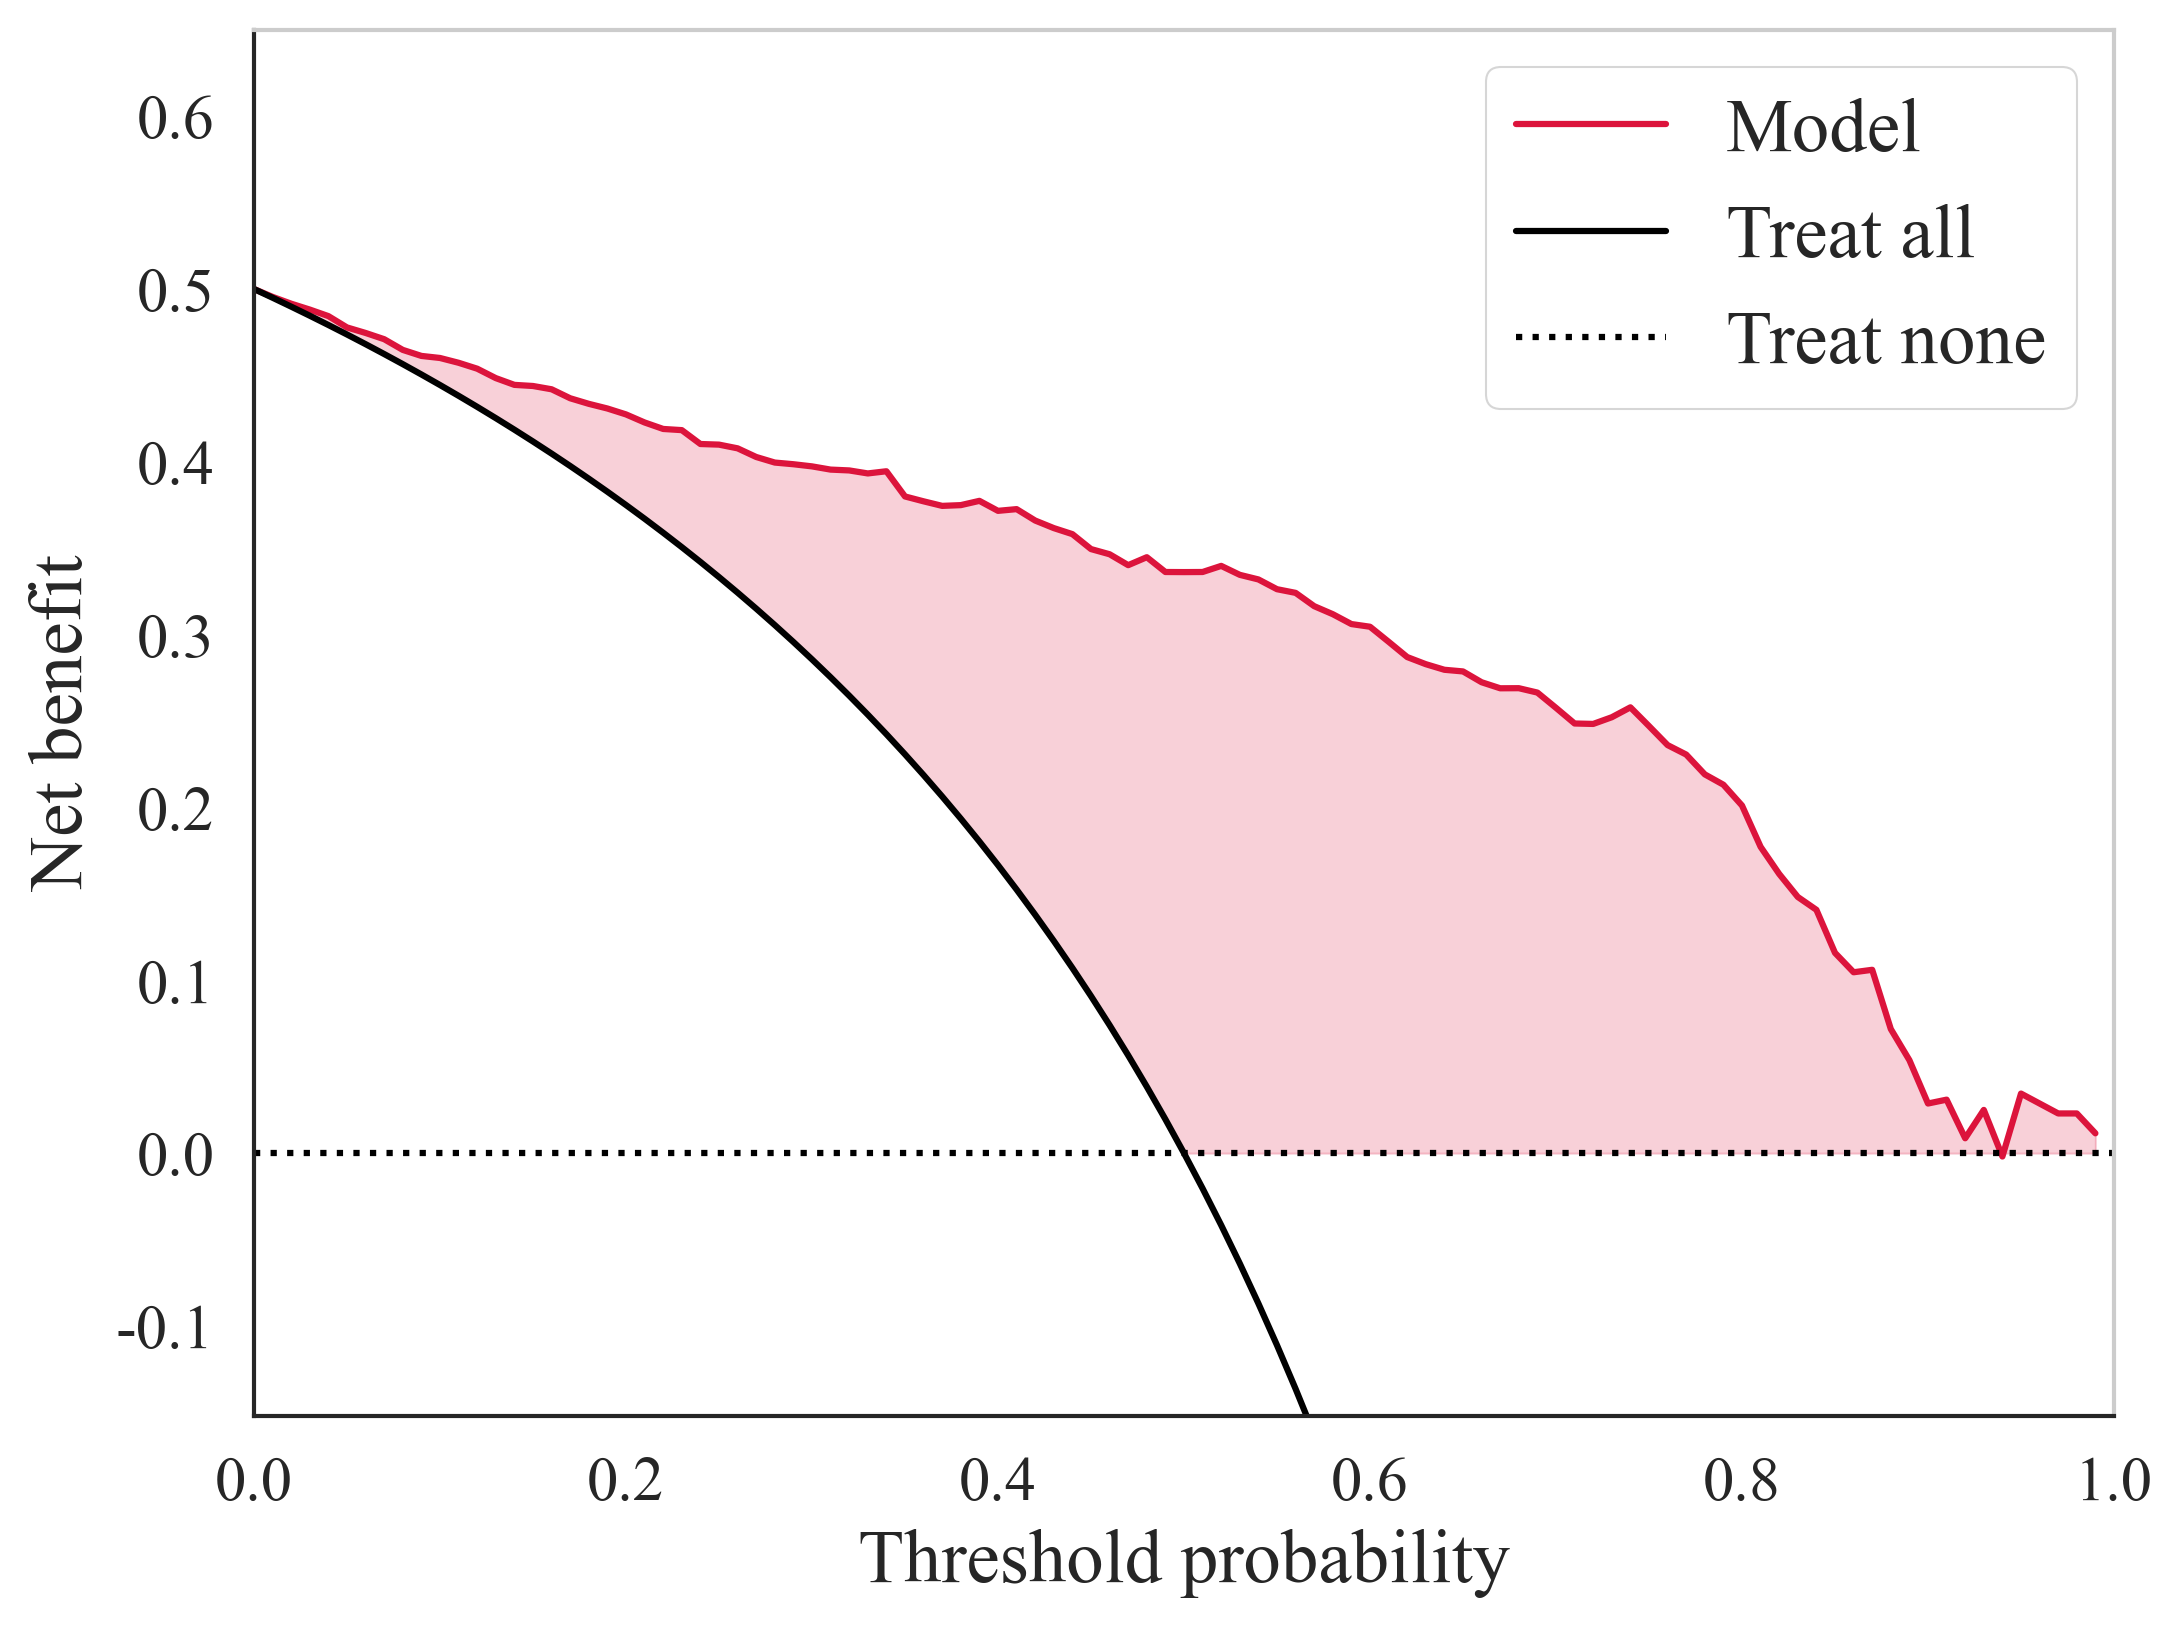

In [100]:
thresh_group = np.arange(0,1,0.01)
net_benefit_model = calculate_net_benefit_model(thresh_group, y_test_scores, y_test)
net_benefit_all = calculate_net_benefit_all(thresh_group, y_test)
fig, ax = plt.subplots(figsize=(8,6),dpi=300)
ax = plot_DCA(ax, thresh_group, net_benefit_model, net_benefit_all)
fig.savefig('DCA.png', dpi = 300)
plt.show()

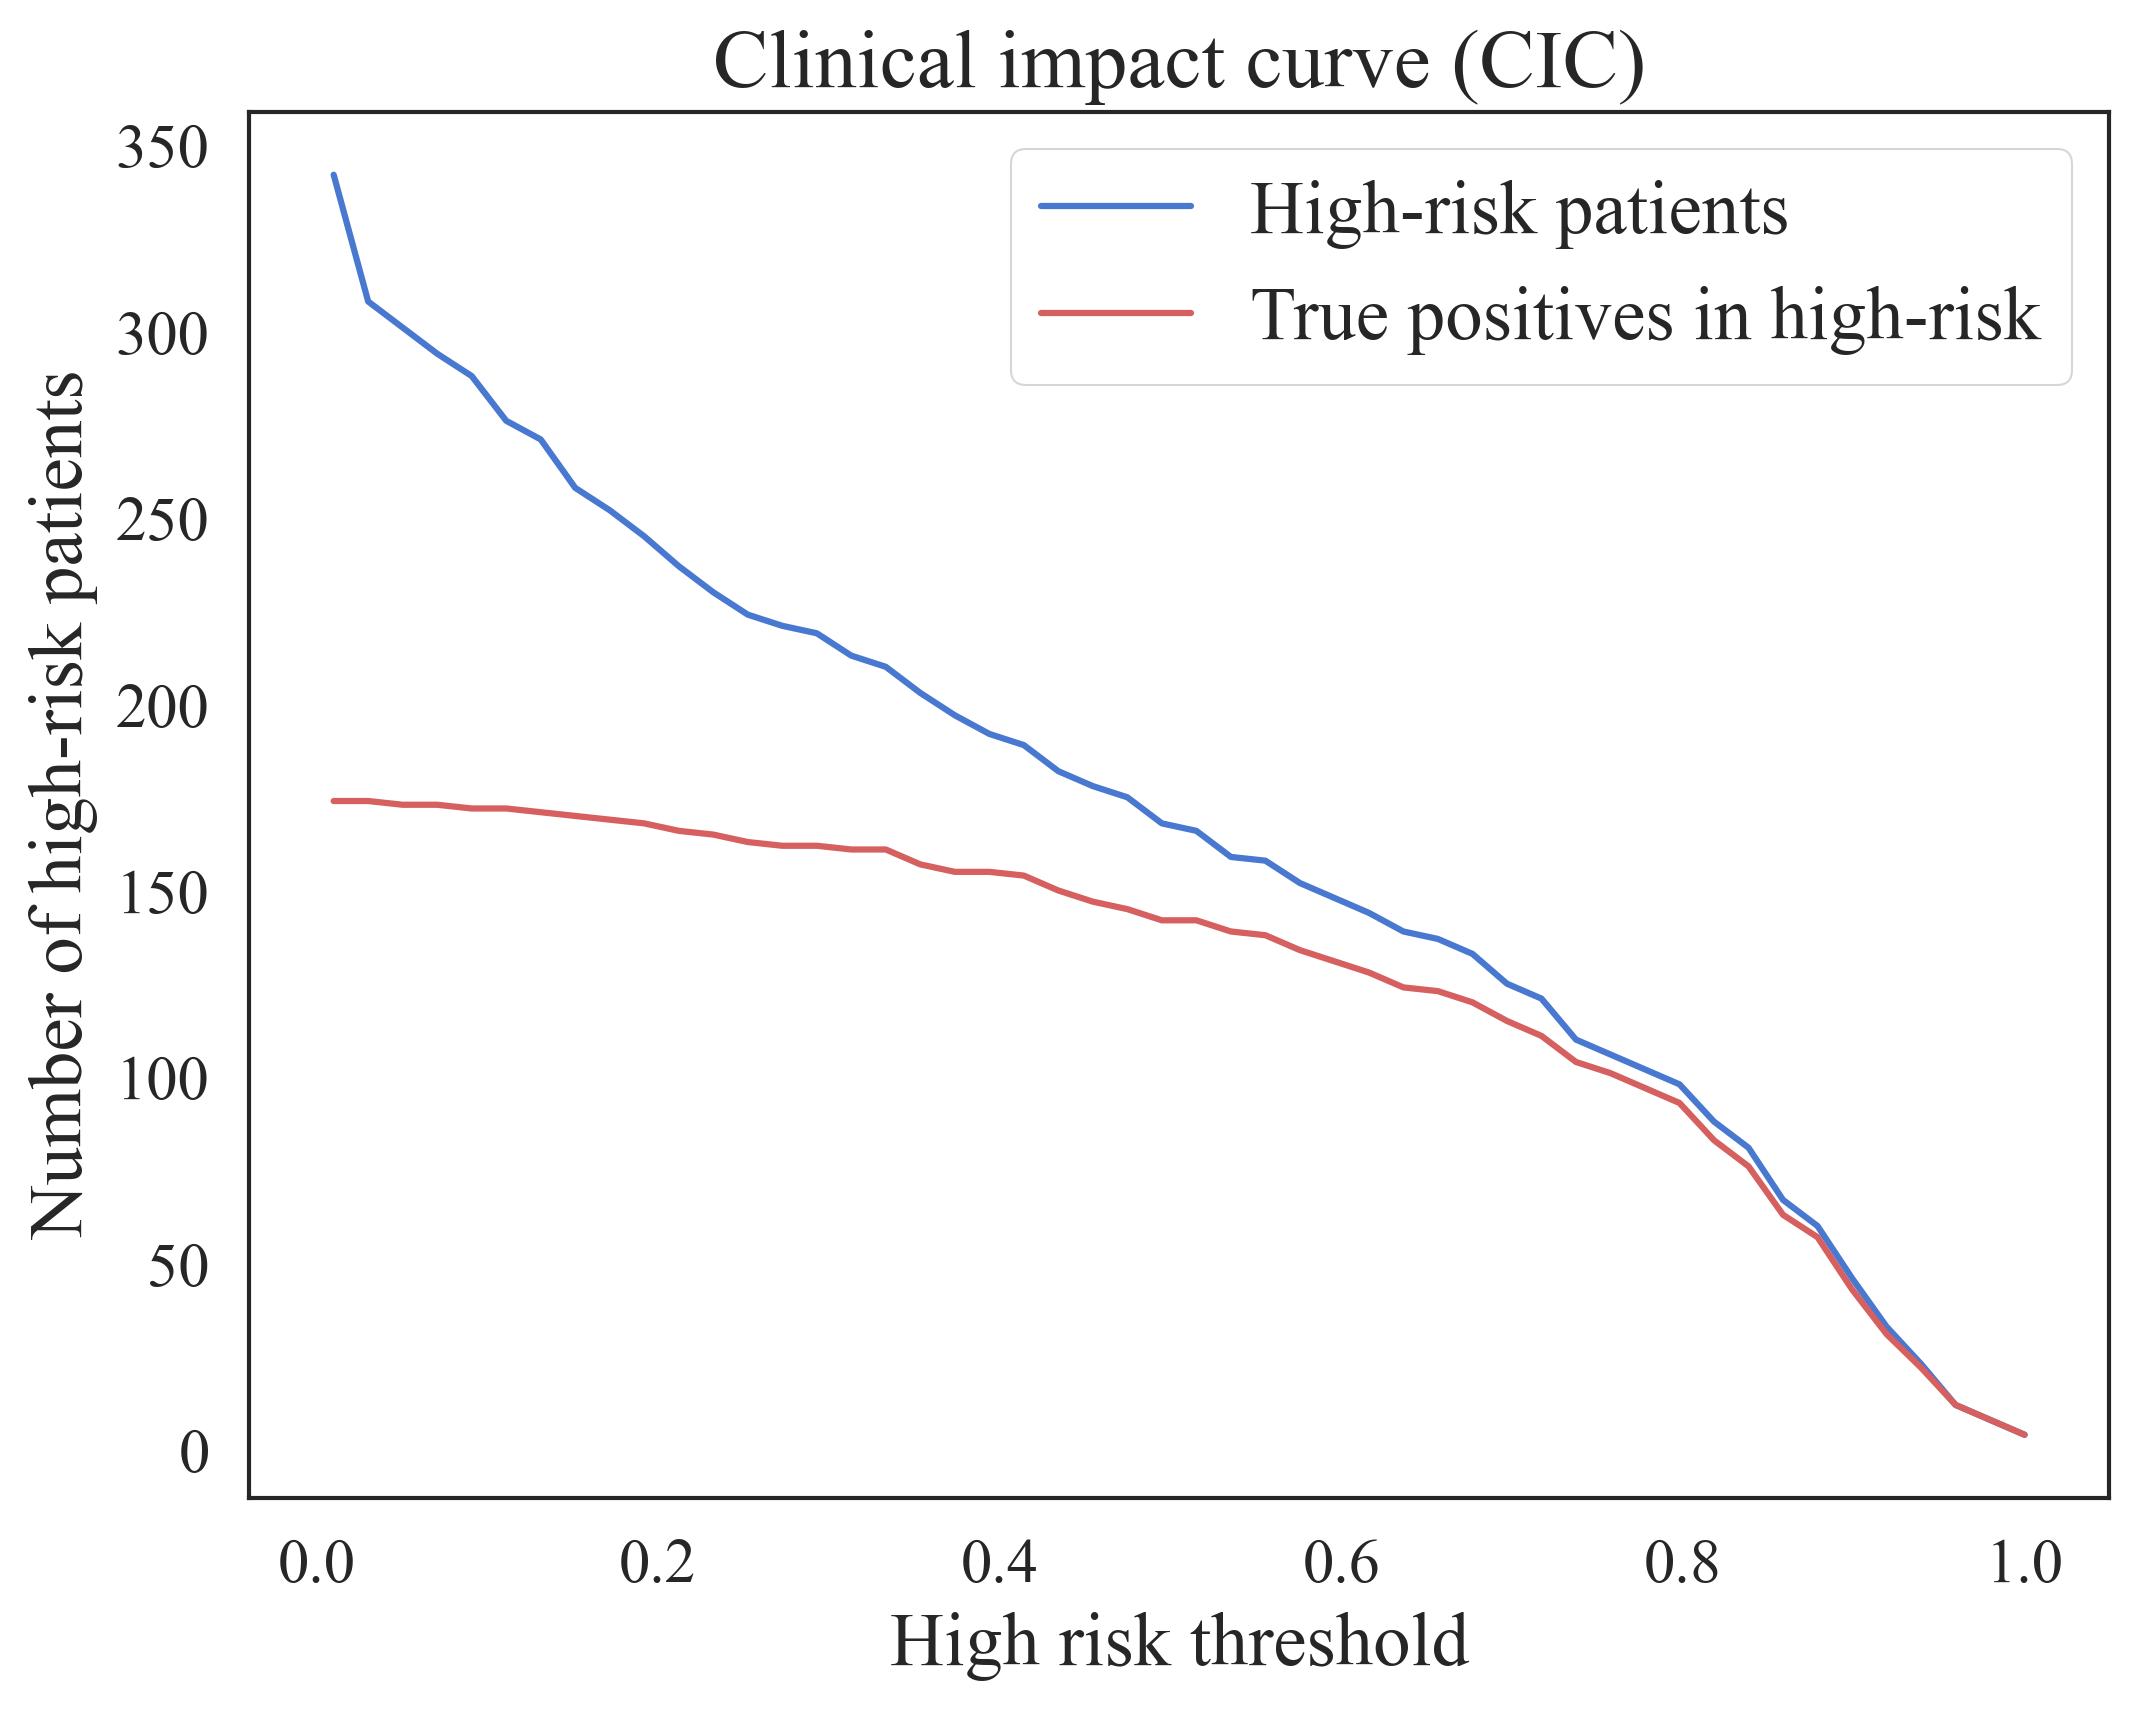

In [98]:
def compute_clinical_impact_curve(y_true, y_pred_prob, thresholds=None):
    """
    计算临床影响曲线（CIC）所需数据
    
    参数:
    y_true -- 真实标签，二进制数组（0或1）
    y_pred_prob -- 预测为阳性（患病）的概率，范围[0,1]
    thresholds -- 可选，自定义阈值列表，默认生成0.01~0.5的100个点
    
    返回:
    thresholds -- 使用的阈值列表
    n_high_risk -- 每个阈值下的高风险患者数量
    tp_high_risk -- 高风险患者中的真实阳性数
    """
    if thresholds is None:
        thresholds = np.linspace(0.01, 1.0, 50)
    
    n_high_risk = []
    tp_high_risk = []
    
    for pt in thresholds:
        # 预测为高风险的患者
        high_risk = y_pred_prob >= pt
        n_high = np.sum(high_risk)
        n_high_risk.append(n_high)
        
        # 高风险中的真实阳性
        tp = np.sum(y_true[high_risk])
        tp_high_risk.append(tp)
    
    return thresholds, np.array(n_high_risk), np.array(tp_high_risk)

def plot_clinical_impact_curve(thresholds, n_high_risk, tp_high_risk, total_samples):
    """ 绘制临床影响曲线（双Y轴） """
    plt.figure(figsize=(8, 6),dpi=300)
    
    # 左轴：高风险患者数量
    # ax1.plot(thresholds, n_high_risk, 'b-', label='High-Risk Patients')
    # ax1.set_xlabel('Risk Threshold')
    # ax1.set_ylabel('Number of High-Risk Patients', color='b')
    # ax1.tick_params(axis='y', labelcolor='b')
    # ax1.set_ylim(0, total_samples)
    
    # # 右轴：高风险中的真实阳性数
    # ax2 = ax1.twinx()
    # ax2.plot(thresholds, tp_high_risk, 'r-', label='True Positives in High-Risk')
    # ax2.set_ylabel('True Positives in High-Risk', color='r')
    # ax2.tick_params(axis='y', labelcolor='r')
    # ax2.set_ylim(0, np.max(tp_high_risk) + 10)

    plt.plot(thresholds, n_high_risk, 'b-', label='High-risk patients')
    plt.plot(thresholds, tp_high_risk, 'r-', label='True positives in high-risk')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel('High risk threshold',fontsize=18)
    plt.ylabel('Number of high-risk patients',fontsize=18)
    plt.title('Clinical impact curve (CIC)',fontsize=20)
    plt.legend(fontsize=18)
    fig.tight_layout()
    plt.savefig('CIC.png')
    plt.show()

    
# 计算CIC数据
thresholds, n_high_risk, tp_high_risk = compute_clinical_impact_curve(y_test, y_test_scores)
    
# 绘制曲线
plot_clinical_impact_curve(thresholds, n_high_risk, tp_high_risk, total_samples=len(y_test))


In [58]:
#10. shap对模型进行解释
model = rf_final
model.fit(X_train_UnS_new_scaled, y_train_UnS_scaled)

RandomForestClassifier(random_state=50)

In [59]:
import joblib
model_name = 'model_old.pkl'
joblib.dump(model,model_name)

['model_old.pkl']

In [60]:
model = joblib.load('model_old.pkl')
y_test_p = model.predict(X_test_new)

In [61]:
X_test_new.head()

AGE  白蛋白-加    脉搏  中性粒细胞与淋巴细胞比值  冠心病  国际标准化比率  血压Low     eGFR  血压high  \
0   86   28.4  99.0     29.204082    1     1.11   45.0   80.799   122.0   
1   84   28.3  74.0      2.647482    1     1.12   68.0   87.703   107.0   
2   80   40.4  61.0      2.268519    1     0.90   60.0   76.270   133.0   
3   65   38.3  65.0      2.775000    0     1.12   59.0  143.810   119.0   
4   89   25.1  94.0     20.586667    0     1.07   69.0  138.928   128.0   

    肌酐-加    BMI  白细胞计数  严重贫血  平均血红蛋白浓度  
0   99.7  24.34  15.25     0     311.0  
1   93.3  21.47   6.16     0     347.0  
2  106.2  23.03   3.94     0     326.0  
3   63.6  22.04   3.49     1     337.0  
4   62.0  24.34  16.41     0     338.0

In [62]:
X_test = X_test_new

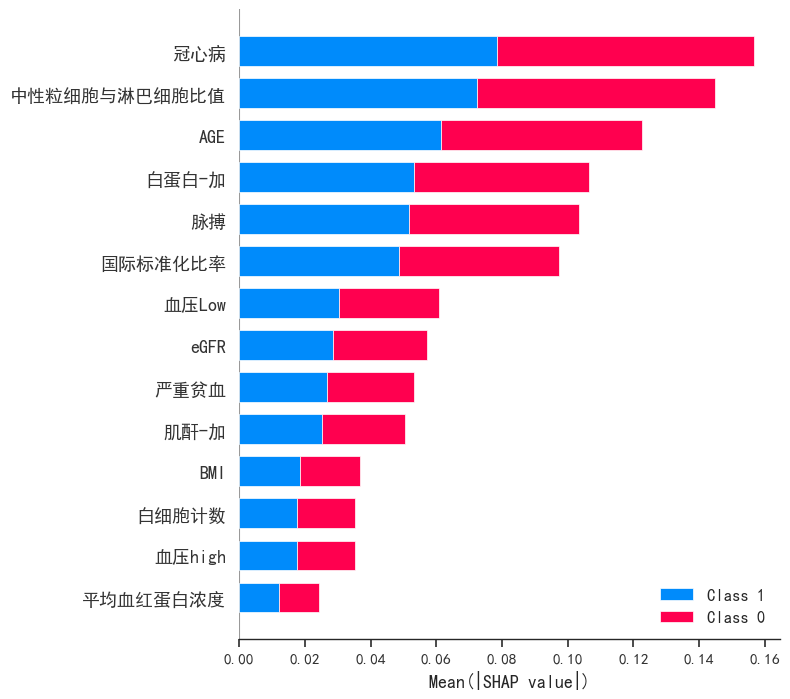

In [63]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
plt.rcParams['font.sans-serif'] = ['SimHei']
shap.summary_plot( shap_values, X_test, feature_names=X_test.columns,show=False,max_display=35,plot_type="bar")
plt.xlabel('Mean(|SHAP value|)')
plt.savefig('shap_bar.png', dpi=300, bbox_inches='tight')
plt.show()

In [61]:
print(shap_values[0].shape)
print(shap_values)

(5206, 14)
[array([[ 0.05911168,  0.0337742 , -0.01824904, ..., -0.00777964,
         0.02316765, -0.03527621],
       [ 0.05175511,  0.02928442,  0.0368907 , ..., -0.0243335 ,
         0.01175809,  0.03723201],
       [-0.01196752, -0.01929784, -0.06533027, ..., -0.01186137,
         0.02751162, -0.0258729 ],
       ...,
       [ 0.04018693,  0.0357497 ,  0.08192832, ..., -0.00493805,
         0.00355263, -0.02023055],
       [-0.06094533, -0.06871816, -0.07008833, ...,  0.00912114,
        -0.00523695, -0.03101875],
       [ 0.0589206 ,  0.04142547,  0.07598813, ..., -0.00956644,
         0.01103266,  0.00270554]]), array([[-0.05911168, -0.0337742 ,  0.01824904, ...,  0.00777964,
        -0.02316765,  0.03527621],
       [-0.05175511, -0.02928442, -0.0368907 , ...,  0.0243335 ,
        -0.01175809, -0.03723201],
       [ 0.01196752,  0.01929784,  0.06533027, ...,  0.01186137,
        -0.02751162,  0.0258729 ],
       ...,
       [-0.04018693, -0.0357497 , -0.08192832, ...,  0.0049380

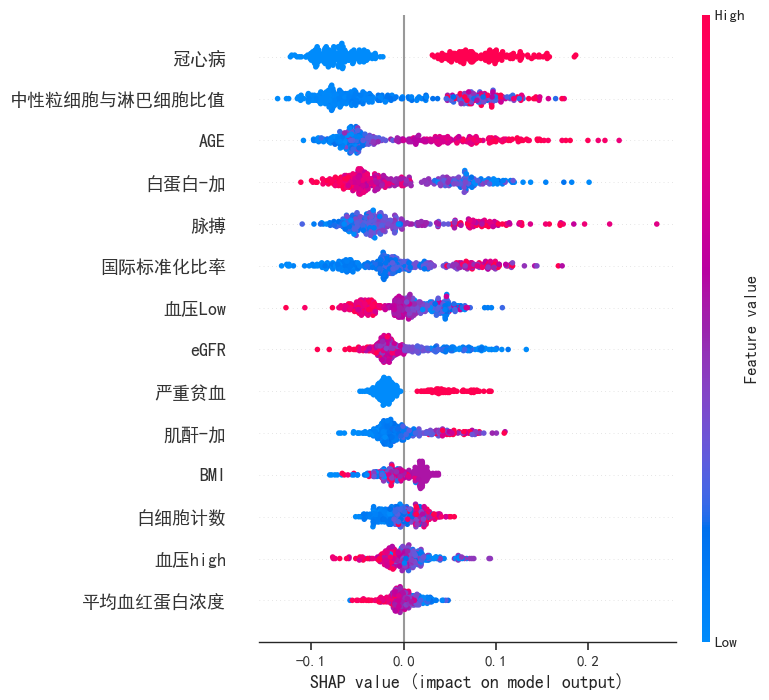

In [64]:
#shap_values中第一个array是阴性，第二个array是阳性
shap.summary_plot(shap_values[1], X_test, feature_names=X_test.columns,show=False,max_display=35)
# plt.xlabel('SHAP value')
plt.savefig('shap_dot.png',dpi=300, bbox_inches='tight')
plt.show()

the class of 312 row is: 0


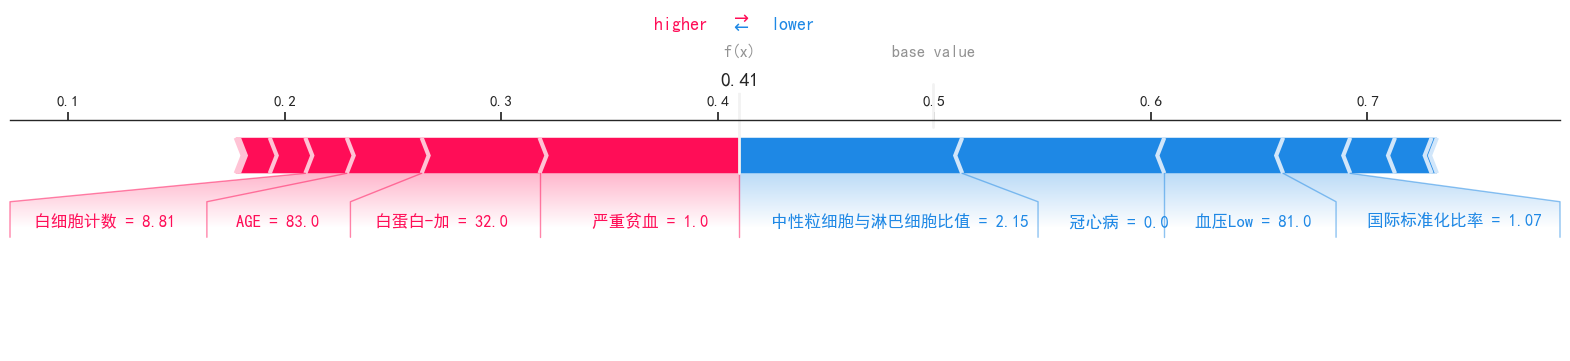

array([ 0.03459793,  0.05443393,  0.00145716, -0.10283564, -0.09333724,
       -0.03099242, -0.05488858, -0.01692041, -0.00244207, -0.02067137,
        0.0164403 ,  0.01911642,  0.09234076,  0.0142544 ])

In [65]:
shap.initjs()
ind=312
print(f"the class of {ind} row is: {list(y_test)[ind]}" )
# plt.figure(figsize=(20, 4))
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
shap.force_plot(explainer.expected_value[1], shap_values[1][ind,:],round(X_test.iloc[ind,:],3),feature_names=X_test.columns,matplotlib=True,show=False)
plt.savefig("ind_neg.png",dpi=300,bbox_inches="tight")
plt.show()
shap_values[1][ind,:]

In [66]:
explainer.expected_value

array([0.50055316, 0.49944684])

the class of 103 row is: 0


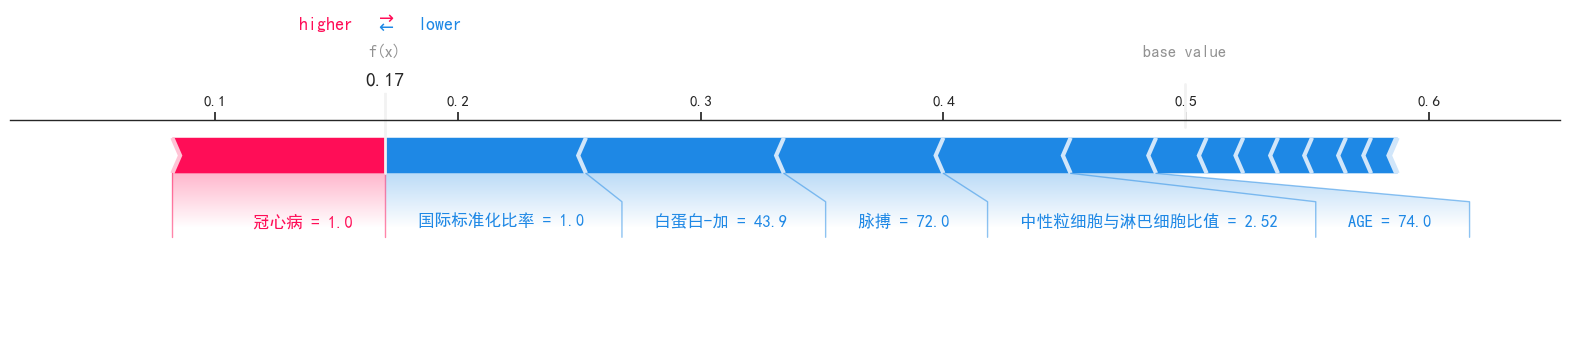

array([-0.03519566, -0.08155122, -0.06574123, -0.05244292,  0.08773674,
       -0.08270043, -0.01033407, -0.01508245, -0.00060984, -0.01403847,
       -0.01398316, -0.01430255, -0.02083598, -0.0103656 ])

In [67]:
shap.initjs()
ind=103
print(f"the class of {ind} row is: {list(y_test)[ind]}" )
# plt.figure(figsize=(20, 4))
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
shap.force_plot(explainer.expected_value[1], shap_values[1][ind,:],round(X_test.iloc[ind,:],3),feature_names=X_test.columns,matplotlib=True,show=False)
plt.savefig("ind_pos.png",dpi=300,bbox_inches="tight")
plt.show()
shap_values[1][ind,:]

In [184]:
y_test[y_test==1]

23      1
27      1
50      1
103     1
115     1
       ..
5110    1
5111    1
5148    1
5168    1
5190    1
Name: group, Length: 174, dtype: int64

In [ ]:
# import seaborn as sns
# shap.force_plot(explainer.expected_value[1], shap_values[1], X_test, feature_names=X_test.columns,show=False)
# #plt.savefig("force_plot.jpg")

In [68]:
X_train_UnS_new_EN = X_train_UnS_new_scaled.rename(columns=dict_name)
X_test_new_EN = X_test_new.rename(columns=dict_name)
X_test_new_EN.head()

Age  Albumin  Pulse        NLR  Coronary heart disease   INR  \
0   86     28.4   99.0  29.204082                       1  1.11   
1   84     28.3   74.0   2.647482                       1  1.12   
2   80     40.4   61.0   2.268519                       1  0.90   
3   65     38.3   65.0   2.775000                       0  1.12   
4   89     25.1   94.0  20.586667                       0  1.07   

   Diastolic blood pressure     eGFR  Systolic blood pressure  \
0                      45.0   80.799                    122.0   
1                      68.0   87.703                    107.0   
2                      60.0   76.270                    133.0   
3                      59.0  143.810                    119.0   
4                      69.0  138.928                    128.0   

   Serum creatinine    BMI  White blood cell count  Severe anemia   MCHC  
0              99.7  24.34                   15.25              0  311.0  
1              93.3  21.47                    6.16              0  347.0  
2             106.2  23.03                    3.94              0  326.0  
3              63.6  22.04                    3.49              1  337.0  
4              62.0  24.34                   16.41              0  338.0

In [69]:
model.fit(X_train_UnS_new_EN, y_train_UnS_scaled)

RandomForestClassifier(random_state=50)

In [70]:
X_test_EN = X_test_new_EN
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_EN)

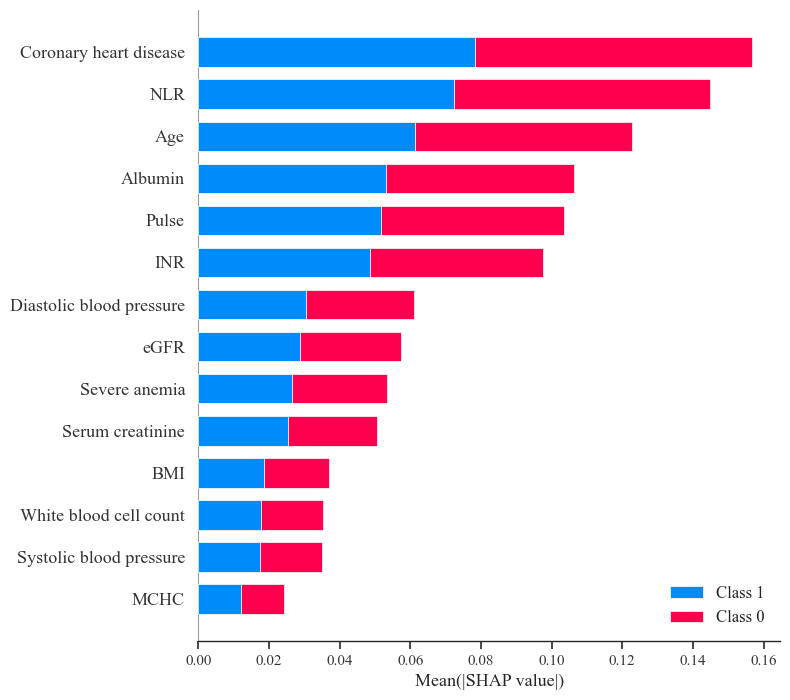

In [71]:
plt.rcParams['font.sans-serif'] = ['Times New Roman']
shap.summary_plot( shap_values, X_test_EN, feature_names=X_test_EN.columns,show=False,max_display=35,plot_type="bar")
plt.xlabel('Mean(|SHAP value|)')
plt.savefig('shap_bar_EN.png', dpi=300, bbox_inches='tight')
plt.show()

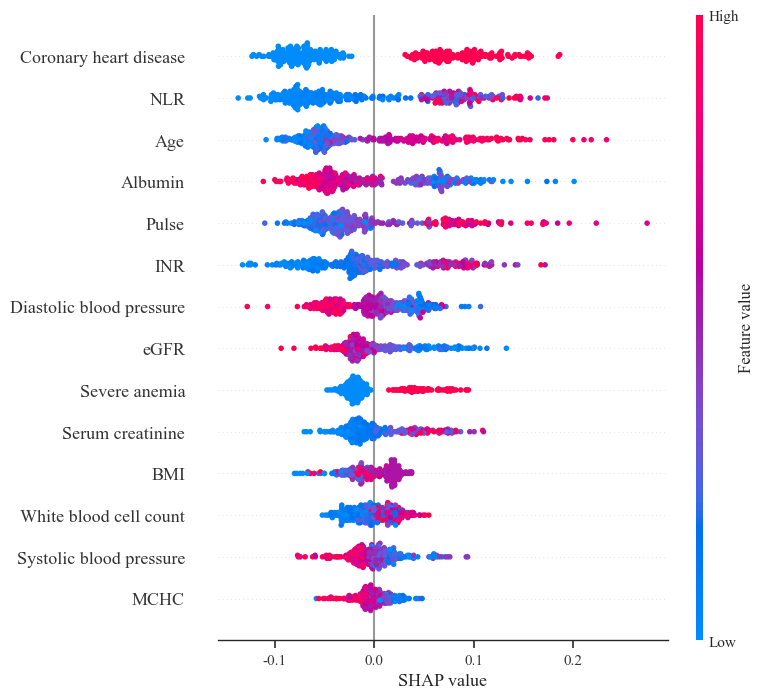

In [72]:
#shap_values中第一个array是阴性，第二个array是阳性
plt.rcParams['font.sans-serif'] = ['Times New Roman']
shap.summary_plot(shap_values[1], X_test_EN, feature_names=X_test_EN.columns,show=False,max_display=35)
plt.xlabel('SHAP value')
plt.savefig('shap_dot_EN.png',dpi=300, bbox_inches='tight')
plt.show()

the class of 312 row is: 0


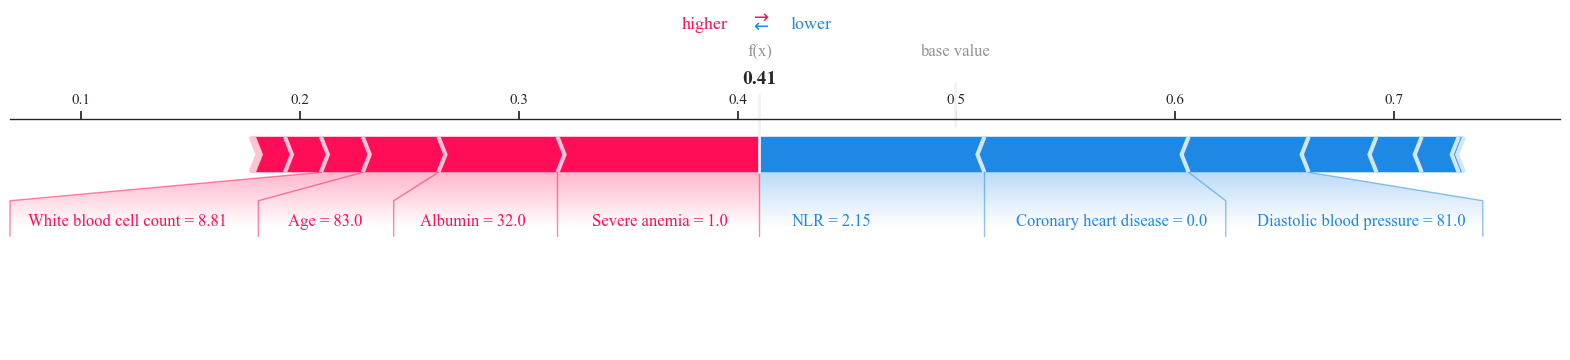

array([ 0.03459793,  0.05443393,  0.00145716, -0.10283564, -0.09333724,
       -0.03099242, -0.05488858, -0.01692041, -0.00244207, -0.02067137,
        0.0164403 ,  0.01911642,  0.09234076,  0.0142544 ])

In [73]:
shap.initjs()
ind=312
print(f"the class of {ind} row is: {list(y_test)[ind]}" )
# plt.figure(figsize=(20, 4))
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.rcParams['axes.unicode_minus'] = False
shap.force_plot(explainer.expected_value[1], shap_values[1][ind,:],round(X_test_EN.iloc[ind,:],3),feature_names=X_test_EN.columns,matplotlib=True,show=False)
plt.savefig("ind_neg_EN.png",dpi=300,bbox_inches="tight")
plt.show()
shap_values[1][ind,:]

the class of 103 row is: 0


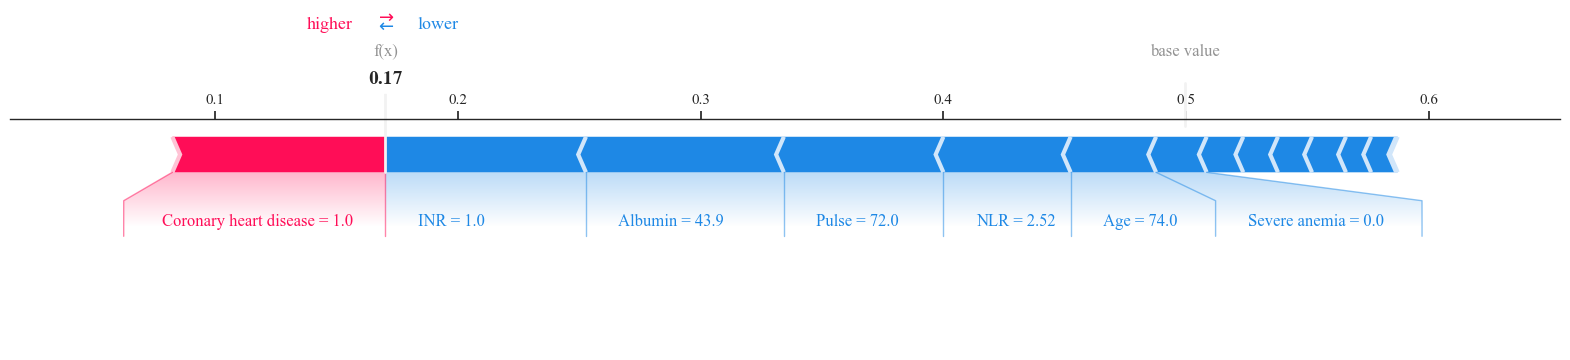

array([-0.03519566, -0.08155122, -0.06574123, -0.05244292,  0.08773674,
       -0.08270043, -0.01033407, -0.01508245, -0.00060984, -0.01403847,
       -0.01398316, -0.01430255, -0.02083598, -0.0103656 ])

In [74]:
shap.initjs()
ind=103
print(f"the class of {ind} row is: {list(y_test)[ind]}" )
# plt.figure(figsize=(20, 4))
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.rcParams['axes.unicode_minus'] = False
shap.force_plot(explainer.expected_value[1], shap_values[1][ind,:],round(X_test_EN.iloc[ind,:],3),feature_names=X_test_EN.columns,matplotlib=True,show=False)
plt.savefig("ind_pos_EN.png",dpi=300,bbox_inches="tight")
plt.show()
shap_values[1][ind,:]

The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.


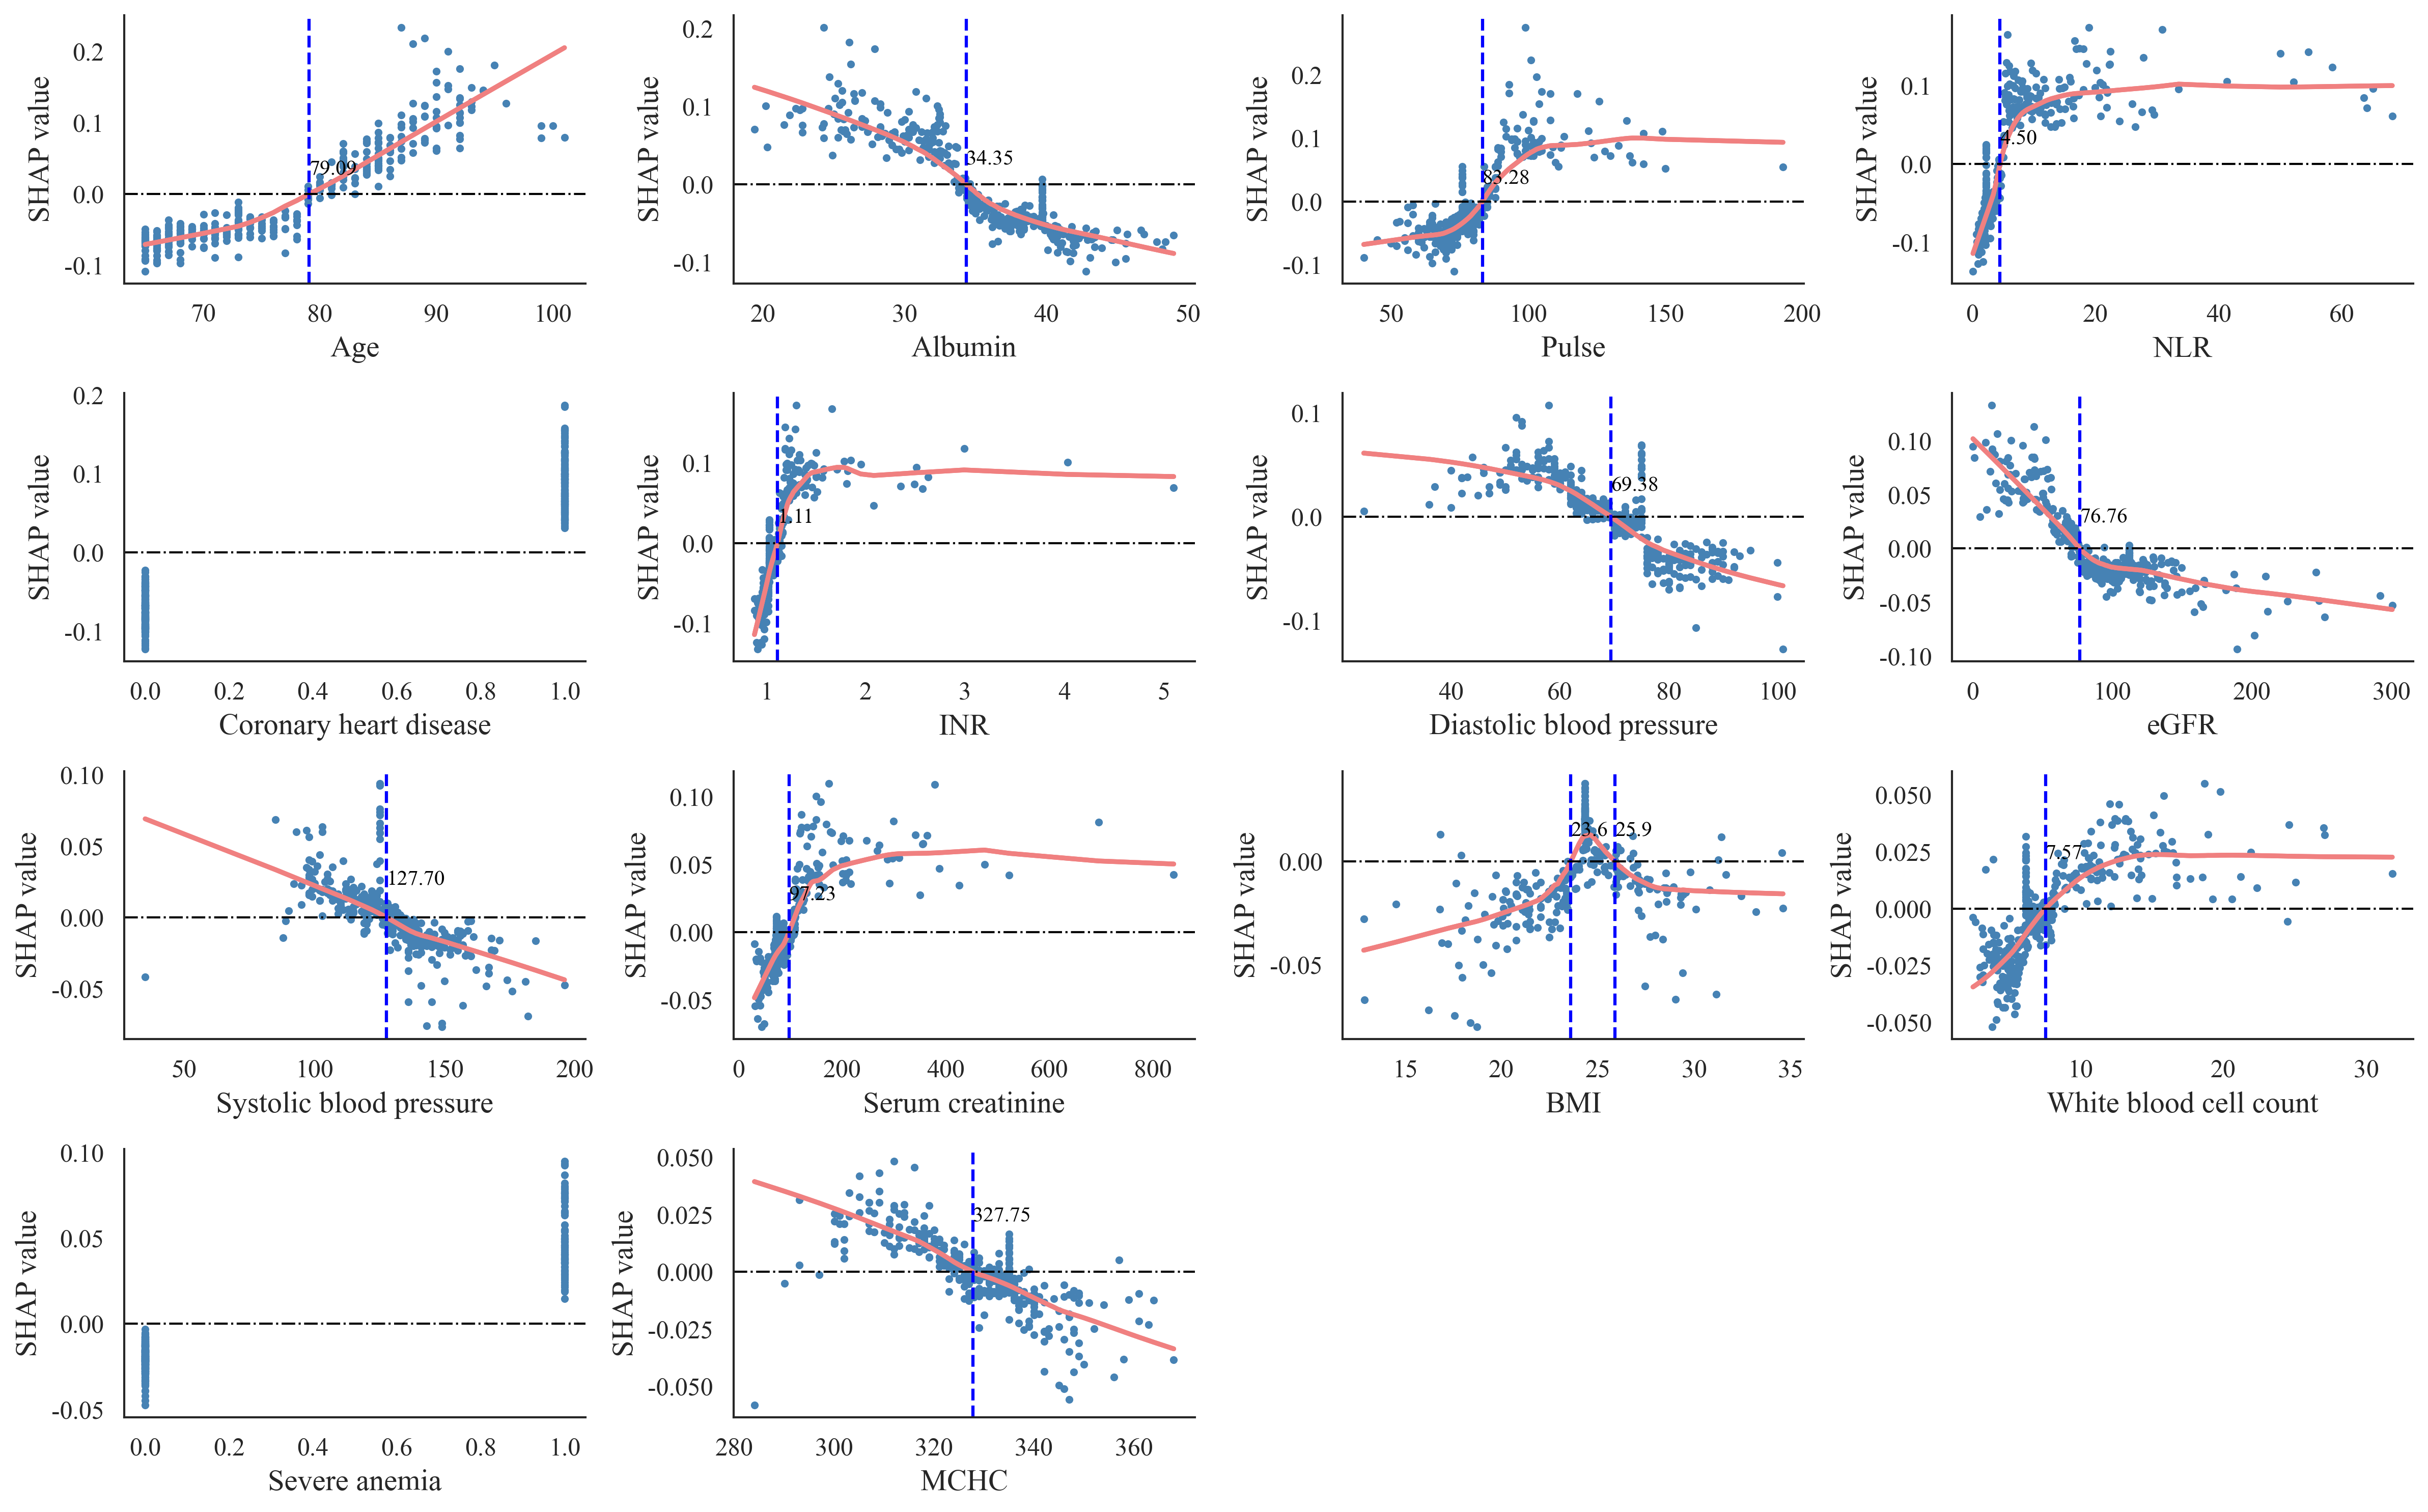

In [76]:
##SHAP依赖图带拟合曲线
import scipy.optimize as optimize
n_rows,n_cols = 4,4
features = X_test_new_EN.columns
fig, axes = plt.subplots(nrows=n_rows, ncols= n_cols, figsize=(16,10),dpi=300)
def find_zero_crossings(x_fit,y_fit):
    crossings = []
    for i in range(1,len(y_fit)):
        if (y_fit[i-1]<0 and y_fit[i]>0) or (y_fit[i-1]>0 and y_fit[i]<0):
            crossing = optimize.fsolve(lambda x: np.interp(x, x_fit,y_fit),x_fit[i])[0]
            crossings.append(crossing)
    return  crossings 
for i, feature in enumerate(features):
    row, col = divmod(i, n_cols) 
    ax = axes[row,col]
    ax.scatter(X_test_new_EN[feature],shap_values[1][:,list(X_test_new_EN.columns).index(feature)], s=10,color='steelblue' )


    if feature != 'Coronary heart disease' and feature != 'Severe anemia' :
    # 添加LOWESS拟合曲线
        sns.regplot(x=X_test_new_EN[feature],y=shap_values[1][:,list(X_test_new_EN.columns).index(feature)],scatter=False, lowess=True,ax=ax,color='lightcoral')
    #获取LOWESS拟合曲线
        lowess_data = sns.regplot(x=X_test_new_EN[feature],y=shap_values[1][:,list(X_test_new_EN.columns).index(feature)],scatter=False, lowess=True,ax=ax,color='lightcoral')
        
        line = lowess_data.get_lines()[0]
        x_fit = line.get_xdata()
        y_fit = line.get_ydata()

    #找出与y=0相交的x
        x_intercepts = find_zero_crossings(x_fit,y_fit)

    #标注交点
        if feature ==  'BMI':
            for x_intercept in x_intercepts:
                ax.axvline(x= x_intercept, color='blue',linestyle='--',label= f'X={x_intercept:.1f}')
                ax.text(x_intercept,0.01,f'{x_intercept:.1f}',color='black',fontsize=10, verticalalignment='bottom')
        else:
            for x_intercept in x_intercepts:
                ax.axvline(x= x_intercept, color='blue',linestyle='--',label= f'X={x_intercept:.2f}')
                ax.text(x_intercept,0.02,f'{x_intercept:.2f}',color='black',fontsize=10, verticalalignment='bottom')
    #添加shap=0的横线
    ax.axhline(y=0, color='black',linestyle='-.',linewidth=1)

    #设置标签和标题
    ax.tick_params(axis='both',labelsize=12)
    ax.set_xlabel(feature, fontsize=14)
    ax.set_ylabel('SHAP value', fontsize=14)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

#移除多余子图
for i in range(len(features), n_rows*n_cols):
    row, col = divmod(i, n_cols)
    fig.delaxes(axes[row,col])

plt.tight_layout()
plt.savefig('shap_15F_lowess.png',bbox_inches='tight')
plt.show()
     

In [ ]:
#####此方法不正确

# def find_optimal_split(feature_name):
#     shap_values_feature = shap_values[1][:,list(X_test_new_EN.columns).index(feature_name)]
#     feature_values = X_test_new_EN[feature_name] 
    
#     data = pd.DataFrame({'FeatureValue':feature_values,'SHAPValue':shap_values_feature})
#     data = data.sort_values(by='SHAPValue')
#     data.to_csv('glucose.csv',index=False)
#     print(data.head(5))
    
#     data['CumulativeSHAP'] = data['SHAPValue'].cumsum()
#     optimal_split_index = np.argmax(np.abs(data['CumulativeSHAP'].diff()))
#     optimal_split_value = data.iloc[optimal_split_index]['FeatureValue']
#     print( data['CumulativeSHAP'])
#     ####可视化
#     plt.figure(figsize=(8,5))
#     plt.plot(data['FeatureValue'],data['CumulativeSHAP'],label='Cumulative SHAP')
#     plt.axvline(optimal_split_value,color='r',linestyle='--',label=f"Split at {optimal_split_value:.2f}")
#     plt.xlabel('Feature')
#     plt.ylabel('Cumulative SHAP value')
#     plt.legend()
#     plt.show()

#     return optimal_split_value

# feature_to_analyze = 'Blood glucose'
# find_optimal_split(feature_to_analyze)

In [ ]:
##SHAP依赖图不带拟合曲线
import scipy.optimize as optimize
n_rows,n_cols = 3,5
features = X_test_new_EN.columns
fig, axes = plt.subplots(nrows=n_rows, ncols= n_cols, figsize=(16,10),dpi=300)
def find_zero_crossings(x_fit,y_fit):
    crossings = []
    for i in range(1,len(y_fit)):
        if (y_fit[i-1]<0 and y_fit[i]>0) or (y_fit[i-1]>0 and y_fit[i]<0):
            crossing = optimize.fsolve(lambda x: np.interp(x, x_fit,y_fit),x_fit[i])[0]
            crossings.append(crossing)
    return  crossings 
for i, feature in enumerate(features):
    row, col = divmod(i, n_cols) 
    ax = axes[row,col]
    ax.scatter(X_test_new_EN[feature],shap_values[1][:,list(X_test_new_EN.columns).index(feature)], s=10,color='steelblue' )

    #添加shap=0的横线
    ax.axhline(y=0, color='black',linestyle='-.',linewidth=1)

    #设置标签和标题
    ax.tick_params(axis='both',labelsize=12)
    ax.set_xlabel(feature, fontsize=14)
    ax.set_ylabel('SHAP value', fontsize=14)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

#移除多余子图
for i in range(len(features), n_rows*n_cols):
    row, col = divmod(i, n_cols)
    fig.delaxes(axes[row,col])

plt.tight_layout()
plt.savefig('shap_15F.png',bbox_inches='tight')
plt.show()